### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

### Loading data

In [3]:
combined_df = pd.read_csv('combined_df_2.csv', index_col='Date', parse_dates=True)


In [4]:
combined_df.shape

(2516, 36216)

In [5]:
returns_df = pd.read_csv('returns_df.csv', index_col='Date', parse_dates=True)

In [6]:
returns_df.shape

(2516, 503)

In [11]:
returns_df = returns_df.rename(columns=lambda x: f"{x}_return")


### Refactoring data

In [14]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

############################
#  A. Parse signals_df columns
############################
new_cols_signals = []
for c in combined_df.columns:
    # Each column is like "AAPL_ao", "AAPL_rsi", etc.
    ticker, indicator = c.split('_', 1)
    new_cols_signals.append((ticker, indicator))

# Create a MultiIndex with levels = [ticker, indicator]
combined_df.columns = pd.MultiIndex.from_tuples(new_cols_signals, 
                                               names=['ticker', 'indicator'])

############################
#  B. Parse returns_df columns
############################



In [16]:
new_cols_returns = []
for c in returns_df.columns:
    # Each column is like "AAPL_return", "MSFT_return", etc.
    ticker, ret_label = c.split('_', 1)
    # We'll store (ticker, 'return') so it's consistent
    new_cols_returns.append((ticker, 'return'))

returns_df.columns = pd.MultiIndex.from_tuples(new_cols_returns, 
                                               names=['ticker', 'field'])

### Cross sectional analysis

In [29]:

# First, handle missing data in combined_df
# Fill NaN values with column means for each ticker
combined_df_filled = combined_df.groupby(level='ticker', axis=1).transform(
    lambda x: x.fillna(x.mean())
)

# Fill any remaining NaNs with 0 (for columns that are all NaN for a ticker)
combined_df_filled = combined_df_filled.fillna(0)

# Now stack the data
signals_long = combined_df_filled.stack(level='ticker')
signals_long.index = signals_long.index.set_names(["date", "ticker"])

# For returns_df, we'll be more conservative and only fill within each ticker
# First create a DataFrame with the same structure as returns_df
returns_df_filled = returns_df.copy()

# Fill forward and then backward within each ticker to handle missing days
for ticker in returns_df.columns.get_level_values('ticker').unique():
    ticker_cols = [col for col in returns_df.columns if col[0] == ticker]
    returns_df_filled[ticker_cols] = returns_df[ticker_cols].fillna(method='ffill').fillna(method='bfill')

# Stack the returns data
returns_long = returns_df_filled.stack(level='ticker')
returns_long.index = returns_long.index.set_names(["date", "ticker"])

# Join the dataframes
df_merged = signals_long.join(returns_long, how="inner")

# Print shape information for debugging
print(f"After preprocessing and joining:")
print(f"signals_long shape: {signals_long.shape}")
print(f"returns_long shape: {returns_long.shape}")
print(f"df_merged shape: {df_merged.shape}")

############################
#  D. Improved regression
############################
coefs_list = []
dates_list = []
stats_list = []  # To store regression statistics

# Calculate min number of stocks needed for regression
all_dates = df_merged.index.get_level_values('date').unique()
min_stocks = max(10, int(len(df_merged.index.get_level_values('ticker').unique()) * 0.05))  # At least 5% of all stocks

print(f"Total unique dates: {len(all_dates)}")
print(f"Minimum stocks required per regression: {min_stocks}")

# Group by date and run regressions
for date, group in df_merged.groupby(level='date'):
    # Drop the date level from the index
    group = group.droplevel('date')
    
    # Make sure 'return' column exists
    if 'return' not in group.columns:
        print(f"Skipping date {date}: No return column")
        continue
    
    # Handle outliers in returns - winsorize at 1% and 99%
    q1 = group['return'].quantile(0.01)
    q99 = group['return'].quantile(0.99)
    group['return'] = group['return'].clip(q1, q99)
    
    # Check if we have sufficient data points (now using our dynamic threshold)
    if group.shape[0] < min_stocks:
        print(f"Skipping date {date}: Only {group.shape[0]} stocks (need {min_stocks})")
        continue
    
    # Extract target variable
    y = group['return']
    
    # Extract features and normalize them (subtract mean, divide by std)
    X = group.drop(columns=['return'])
    X = (X - X.mean()) / X.std().replace(0, 1)  # Replace zero std with 1 to avoid division by zero
    
    # Add constant after normalization
    X = sm.add_constant(X)
    
    # Remove any residual NaNs from normalization
    valid_rows = ~y.isna() & ~X.isna().any(axis=1)
    if valid_rows.sum() < min_stocks:
        print(f"Skipping date {date}: Only {valid_rows.sum()} valid rows after NaN removal")
        continue
    
    y = y[valid_rows]
    X = X[valid_rows]
    
    # Check for multicollinearity using VIF (Variance Inflation Factor)
    # Only include variables with VIF < 10 to reduce multicollinearity
    X_no_const = X.drop(columns=['const'])
    vif_data = pd.DataFrame()
    vif_data["feature"] = X_no_const.columns
    
    # Only compute VIF if we have enough data
    if X_no_const.shape[1] > 1 and X_no_const.shape[0] > X_no_const.shape[1]:
        try:
            # Calculate VIF for each feature
            from statsmodels.stats.outliers_influence import variance_inflation_factor
            vif_data["VIF"] = [variance_inflation_factor(X_no_const.values, i) 
                             for i in range(X_no_const.shape[1])]
            
            # Keep only features with VIF < 10
            high_vif_features = vif_data[vif_data["VIF"] > 10]["feature"].tolist()
            if high_vif_features:
                X = X.drop(columns=high_vif_features)
        except Exception as e:
            print(f"VIF calculation error on date {date}: {e}")
    
    try:
        model = sm.OLS(y, X).fit()
        coefs_list.append(model.params)
        dates_list.append(date)
        
        # Store regression statistics
        stats_list.append({
            'date': date,
            'n_stocks': len(y),
            'r_squared': model.rsquared,
            'adj_r_squared': model.rsquared_adj
        })
        
        if len(coefs_list) % 50 == 0:
            print(f"Successfully processed {len(coefs_list)} days")
            
    except Exception as e:
        print(f"Regression error on date {date}: {e}")
        continue

# Check if we have any successful regressions
if not coefs_list:
    print("No successful regressions were performed. Check your data.")
else:
    # Combine the daily regression coefficients
    coefs_df = pd.DataFrame(coefs_list, index=dates_list)
    
    # Create a dataframe of regression statistics
    regression_stats = pd.DataFrame(stats_list)
    regression_stats.set_index('date', inplace=True)
    
    print(f"\nSuccessfully ran {len(coefs_list)} daily regressions out of {len(all_dates)} possible days")
    print(f"Coefficients dataframe shape: {coefs_df.shape}")
    print(f"Average R-squared: {regression_stats['r_squared'].mean():.4f}")
    
    # Calculate Fama-MacBeth statistics
    mean_coefs = coefs_df.mean()
    std_coefs = coefs_df.std()
    T = coefs_df.shape[0]
    
    # Calculate t-stats
    t_stats = mean_coefs / (std_coefs / np.sqrt(T))
    
    # Calculate p-values
    p_values = 2 * (1 - abs(t_stats).apply(lambda t: min(0.9999, stats.t.cdf(abs(t), df=T-1))))
    
    results = pd.DataFrame({
        'Mean': mean_coefs,
        'Std': std_coefs,
        'T-Stat': t_stats,
        'P-value': p_values,
        'Significant': p_values < 0.05
    })
    
    print("\nFama–MacBeth Regression Results:")
    print(results)
    
    # Output the most significant factors
    print("\nTop 10 Most Significant Factors:")
    print(results.sort_values('P-value').head(10))

C:\Users\PushkarJain\AppData\Local\Temp\ipykernel_27332\1135493200.py:6: FutureWarning: DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.
  combined_df_filled = combined_df.groupby(level='ticker', axis=1).transform(
C:\Users\PushkarJain\anaconda3\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: invalid value encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\PushkarJain\AppData\Local\Temp\ipykernel_27332\1135493200.py:14: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  signals_long = combined_df_filled.stack(level='ticker')
C:\Users\PushkarJain\AppData\Local\Temp\ipykernel_27332\1135493200.py:24: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future 

After preprocessing and joining:
signals_long shape: (1265548, 72)
returns_long shape: (1263032, 1)
df_merged shape: (1263032, 73)
Total unique dates: 2516
Minimum stocks required per regression: 25


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\sta

Skipping date 2015-01-27 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\sta

Skipping date 2015-03-02 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-03-03 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-03-04 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-03-05 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-03-06 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-03-09 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-03-10 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-03-11 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-03-12 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-03-13 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-03-16 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
C:\Users\PushkarJain\anaconda3\Lib\site-pac

Successfully processed 50 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Skipping date 2015-04-20 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-04-21 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-04-22 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-04-23 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-04-24 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-04-27 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-04-28 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-04-29 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-04-30 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-05-01 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-05-04 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\numpy\core\_methods.py:49: RuntimeWarning: overflow encountered in reduce


Skipping date 2015-05-05 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-05-06 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.p

Skipping date 2015-05-28 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-05-29 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-06-01 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-06-02 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-06-03 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _e

Skipping date 2015-06-04 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-06-05 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-06-08 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-06-09 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _e

Skipping date 2015-06-10 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-06-11 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-06-12 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-06-15 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-06-16 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _e

Skipping date 2015-06-17 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-06-18 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-06-19 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-06-22 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-06-23 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-06-24 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-06-25 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-06-26 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-06-29 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-06-30 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _e

Skipping date 2015-07-01 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-07-02 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-07-06 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-07-07 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-07-08 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-07-09 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _e

Skipping date 2015-07-10 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-07-13 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-07-14 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-07-15 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-07-16 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-07-17 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _e

Skipping date 2015-07-20 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-07-21 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.p

Skipping date 2015-08-20 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-08-21 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-08-24 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-08-25 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-08-26 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1785: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.uncentered_tss
C:\Users\PushkarJain\anaconda3\Lib\site-packages\pandas\core\nanops.py:1016: RuntimeWarning: overflow encountered in square
  sqr = _ensure_numeric((avg - values) ** 2)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1785: R

Skipping date 2015-09-01 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-09-02 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-09-03 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-09-04 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-09-08 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Successfully processed 100 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Skipping date 2015-09-25 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-09-28 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-09-29 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-09-30 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-10-01 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-10-02 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-10-05 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-10-06 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-10-07 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-10-08 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-10-09 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-10-12 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-10-13 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-10-14 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Skipping date 2015-11-03 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-11-04 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Skipping date 2015-12-02 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-12-03 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-12-04 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-12-07 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2015-12-08 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 150 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Skipping date 2016-02-01 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-02-02 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-02-03 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-02-04 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-02-05 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-02-08 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-02-09 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-02-10 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-02-11 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-02-12 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-02-16 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-02-17 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-02-18 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-02-19 00:00:00: Only 0 valid rows after NaN removal
Skippi

C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 200 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Skipping date 2016-03-30 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-03-31 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-04-01 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-04-04 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-04-05 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-04-06 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Skipping date 2016-04-28 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-04-29 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-05-02 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-05-03 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Skipping date 2016-05-24 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-05-25 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-05-26 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-05-27 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-05-31 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-06-01 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-06-02 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-06-03 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-06-06 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Skipping date 2016-06-28 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-06-29 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-06-30 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Successfully processed 250 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Skipping date 2016-07-21 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-07-22 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-07-25 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-07-26 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-07-27 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Skipping date 2016-08-16 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Skipping date 2016-09-23 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-09-26 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-09-27 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-09-28 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-09-29 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-09-30 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-10-03 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-10-04 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-10-05 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-10-06 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-10-07 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-10-10 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-10-11 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2016-10-12 00:00:00: Only 0 valid rows after NaN removal
Skippi

C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Successfully processed 300 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Skipping date 2017-01-03 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-01-04 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-01-05 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-01-06 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-01-09 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-01-10 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-01-11 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-01-12 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-01-13 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-01-17 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-01-18 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-01-19 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-01-20 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-01-23 00:00:00: Only 0 valid rows after NaN removal
Skippi

C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 350 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 400 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Skipping date 2017-08-15 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-08-16 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-08-17 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 450 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Skipping date 2017-09-22 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-09-25 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-09-26 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Skipping date 2017-10-17 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-10-18 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-10-19 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-10-20 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-10-23 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-10-24 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-10-25 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-10-26 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-10-27 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-10-30 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-10-31 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-11-01 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-11-02 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-11-03 00:00:00: Only 0 valid rows after NaN removal
Skippi

C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Skipping date 2017-12-18 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-12-19 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-12-20 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-12-21 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2017-12-22 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 500 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Skipping date 2018-01-16 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Skipping date 2018-02-12 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 550 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Skipping date 2018-05-31 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2018-06-01 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2018-06-04 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2018-06-05 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2018-06-06 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


Successfully processed 600 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 650 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 700 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 750 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 800 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Skipping date 2019-05-23 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2019-05-24 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2019-05-28 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2019-05-29 00:00:00: Only 0 valid rows after NaN removal
Skipping date 2019-05-30 00:00:00: Only 0 valid rows after NaN removal


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 850 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 900 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 950 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1000 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1050 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1100 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1150 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1200 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1250 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1300 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1350 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1400 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1450 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1500 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1550 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1600 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1650 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1700 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1750 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1800 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1850 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1900 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 1950 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 2000 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 2050 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 2100 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 2150 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out

Successfully processed 2200 days


C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
C:\Users\PushkarJain\anaconda3\Lib\site-packages\statsmodels\stats\out


Successfully ran 2244 daily regressions out of 2516 possible days
Coefficients dataframe shape: (2244, 26)
Average R-squared: 0.0041

Fama–MacBeth Regression Results:
                    Mean           Std     T-Stat   P-value  Significant
const       4.274285e-04  1.163527e-02   1.740197  0.081962        False
stc        -6.015553e-04  8.489471e-04 -33.566524  0.000200         True
amat        8.066416e-04  1.143037e-03  33.429636  0.000200         True
decreasing  0.000000e+00           NaN        NaN  0.000200         True
increasing  0.000000e+00           NaN        NaN  0.000200         True
ttm_trend   1.996700e-03  1.827063e-03  51.769113  0.000200         True
nvi         3.533386e-04  1.226879e-03  13.642707  0.000200         True
pvi         7.639311e-04  1.994396e-03  18.144884  0.000200         True
fisher      1.414254e-04  8.620742e-04   7.771309  0.000200         True
psl         1.600888e-03  1.633407e-03  46.427787  0.000200         True
ad          1.005321e-04  1.1

In [33]:
market_returns = pd.read_csv('market_returns.csv', index_col='Date', parse_dates=True)


In [35]:
market_returns = market_returns.drop(columns=['Unnamed: 2', 'Unnamed: 3'])
market_returns.head()

,Market_Returns
Date,
2015-01-02,-0.000340
2015-01-05,-0.018278
2015-01-06,-0.008893
2015-01-07,0.011630
2015-01-08,0.017888


In [37]:
market_returns.columns

Index(['Market_Returns'], dtype='object')

### Time series analysis

In [39]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def select_top_indicators(results_df, n=20):
    """
    Select the top n indicators based on statistical significance from Fama-MacBeth results.
    
    Parameters:
    results_df: DataFrame with Fama-MacBeth regression results
    n: Number of top indicators to select
    
    Returns:
    List of top indicator names
    """
    # Sort by absolute t-statistic (higher = more significant)
    # Alternatively, can sort by p-value (lower = more significant)
    if 'P-value' in results_df.columns:
        sorted_indicators = results_df.sort_values('P-value').index
    else:
        sorted_indicators = results_df.sort_values('T-Stat', key=abs, ascending=False).index
    
    # Filter out the constant term if present
    sorted_indicators = [x for x in sorted_indicators if x != 'const']
    
    # Return top n indicators
    return sorted_indicators[:n]

def run_time_series_for_top_indicators(combined_df, returns_df, market_returns_df, fama_macbeth_results, top_n=20):
    """
    Run time-series regressions for each stock using only the top significant indicators
    from Fama-MacBeth analysis.
    
    Parameters:
    combined_df: DataFrame with MultiIndex columns (ticker, indicator)
    returns_df: DataFrame with MultiIndex columns (ticker, field)
    market_returns_df: DataFrame with market returns
    fama_macbeth_results: DataFrame with Fama-MacBeth regression results
    top_n: Number of top indicators to analyze
    
    Returns:
    Dictionary of DataFrames with analysis results
    """
    print(f"Selecting top {top_n} indicators from Fama-MacBeth results...")
    
    # Select top indicators
    top_indicators = select_top_indicators(fama_macbeth_results, n=top_n)
    print(f"Top {top_n} indicators selected: {', '.join(top_indicators[:5])}...")
    
    # Get unique tickers
    tickers = combined_df.columns.get_level_values('ticker').unique()
    print(f"Found {len(tickers)} tickers for analysis")
    
    # Initialize result dataframes
    p_values = pd.DataFrame(index=tickers, columns=top_indicators)
    t_stats = pd.DataFrame(index=tickers, columns=top_indicators)
    betas = pd.DataFrame(index=tickers, columns=top_indicators)
    r_squared = pd.DataFrame(index=tickers, columns=top_indicators)
    
    # Make sure market returns is properly formatted
    market_returns = market_returns_df['Market_Returns']
    
    print("Running time-series regressions for each stock and selected indicator...")
    
    # Iterate through each ticker
    for ticker in tqdm(tickers):
        # Get returns for this ticker
        try:
            ticker_returns = returns_df.xs(ticker, axis=1, level='ticker')
            
            # Skip if returns are missing
            if ticker_returns.empty or ticker_returns.iloc[:, 0].isna().all():
                continue
                
            # Rename column to 'return' for clarity
            ticker_returns.columns = ['return']
            
            # Merge with market returns
            ticker_data = ticker_returns.join(market_returns, how='inner')
            
            # Skip if not enough data points after joining
            if ticker_data.shape[0] < 252:  # Require at least 1 year of data
                continue
        except Exception as e:
            print(f"Error processing returns for {ticker}: {e}")
            continue
            
        # Run regression for each top indicator
        for indicator in top_indicators:
            try:
                # Get signal data for this ticker and indicator
                try:
                    signal_values = combined_df.xs((ticker, indicator), axis=1)
                except KeyError:
                    # Skip if this ticker doesn't have this indicator
                    continue
                
                # Skip if signal values are missing
                if signal_values.isna().all():
                    continue
                
                # Merge signal with returns data
                regression_data = ticker_data.copy()
                regression_data[indicator] = signal_values
                
                # Skip if not enough data after joining
                if regression_data.shape[0] < 252:
                    continue
                
                # Normalize the signal (z-score normalization)
                signal_mean = regression_data[indicator].mean()
                signal_std = regression_data[indicator].std()
                
                # Skip if signal has no variation
                if signal_std == 0:
                    continue
                    
                regression_data[indicator] = (regression_data[indicator] - signal_mean) / signal_std
                
                # Drop rows with NaN
                regression_data = regression_data.dropna()
                
                # Prepare regression variables
                y = regression_data['return']
                X = regression_data[['Market_Returns', indicator]]
                X = sm.add_constant(X)
                
                # Run regression
                model = sm.OLS(y, X).fit()
                
                # Store results
                p_values.loc[ticker, indicator] = model.pvalues[indicator]
                t_stats.loc[ticker, indicator] = model.tvalues[indicator]
                betas.loc[ticker, indicator] = model.params[indicator]
                r_squared.loc[ticker, indicator] = model.rsquared
                
            except Exception as e:
                # print(f"Error in regression for {ticker}, {indicator}: {e}")
                continue
    
    print("Time series regression analysis complete!")
    
    # Summarize results
    significant_counts = (p_values < 0.05).sum()
    print("\nNumber of stocks with significant signals (p < 0.05):")
    print(significant_counts.sort_values(ascending=False))
    
    # Calculate additional summary statistics
    summary_stats = pd.DataFrame({
        'Significant_Count': significant_counts,
        'Significant_Percent': (significant_counts / p_values.count()) * 100,
        'Positive_Effect': (betas > 0).sum(),
        'Negative_Effect': (betas < 0).sum(),
        'Avg_R_Squared': r_squared.mean(),
        'Avg_Beta': betas.mean()
    })
    
    summary_stats = summary_stats.sort_values('Significant_Percent', ascending=False)
    print("\nSummary statistics:")
    print(summary_stats)
    
    # Return all results
    results = {
        'p_values': p_values,
        't_stats': t_stats,
        'betas': betas,
        'r_squared': r_squared,
        'significant_counts': significant_counts,
        'summary_stats': summary_stats,
        'top_indicators': top_indicators
    }
    
    return results


In [41]:
# Run the analysis with your existing dataframes
time_series_results = run_time_series_for_top_indicators(
    combined_df,           # Your signals dataframe
    returns_df,            # Your returns dataframe
    market_returns,     # Your market returns with 'Market_Returns' column
    results,  # Results from your Fama-MacBeth regression
    top_n=20               # Number of top indicators to analyze
)

# Get the p-values matrix (tickers as rows, signals as columns)
p_values_matrix = time_series_results['p_values']

# Save key results to CSV
p_values_matrix.to_csv('top_signals_pvalues_by_stock.csv')
time_series_results['summary_stats'].to_csv('top_signals_summary_stats.csv')

Selecting top 20 indicators from Fama-MacBeth results...
Top 20 indicators selected: efi, er, hwc, kvo, rvi...
Found 503 tickers for analysis
Running time-series regressions for each stock and selected indicator...


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [01:22<00:00,  6.07it/s]


Time series regression analysis complete!

Number of stocks with significant signals (p < 0.05):
efi           502
rvi           502
decreasing    502
increasing    502
ttm_trend     501
psl           501
amat          501
kvo           499
cti           495
aroon         473
fisher        379
pvol          238
er            222
pvt           136
stc           133
pvi           129
kst            27
nvi            19
ad             10
hwc             0
dtype: int64

Summary statistics:
            Significant_Count  Significant_Percent  Positive_Effect  \
efi                       502           100.000000              502   
rvi                       502           100.000000              502   
decreasing                502           100.000000                0   
increasing                502           100.000000              502   
ttm_trend                 501            99.800797              502   
psl                       501            99.800797              502   
amat        

### Lasso Regression

In [43]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from tqdm import tqdm

def categorize_signals(signals_list):
    """
    Categorize signals based on the provided mapping.
    
    Returns:
    Dictionary mapping categories to lists of signals in that category
    """
    # Define categories based on the provided information
    categories = {
        'trend': ['decreasing', 'increasing', 'ttm_trend', 'amat', 'aroon'],
        'momentum': ['psl', 'cti', 'fisher', 'er'],
        'volume': ['efi', 'kvo', 'pvol'],
        'volatility': ['rvi']
    }
    
    # Create a reverse mapping from signal to category
    signal_to_category = {}
    for category, signals in categories.items():
        for signal in signals:
            signal_to_category[signal] = category
    
    # Organize all provided signals by category
    categorized = defaultdict(list)
    for signal in signals_list:
        # Extract the base signal name from the full indicator name (in case they have suffixes)
        base_signal = None
        for signal_key in signal_to_category.keys():
            if signal_key in signal.lower():
                base_signal = signal_key
                break
        
        if base_signal:
            category = signal_to_category[base_signal]
            categorized[category].append(signal)
        else:
            # If no category found, put in 'other'
            categorized['other'].append(signal)
    
    return categorized

def run_lasso_by_category(combined_df, returns_df, time_series_results, top_n=20):
    """
    Run LASSO regression for each category of signals to select the most significant ones.
    
    Parameters:
    combined_df: DataFrame with MultiIndex columns (ticker, indicator)
    returns_df: DataFrame with MultiIndex columns (ticker, field)
    time_series_results: Results from previous time series analysis
    top_n: Number of top indicators to analyze
    
    Returns:
    Dictionary with results by category
    """
    print("Extracting top indicators from time series results...")
    
    # Extract the top indicators from the summary statistics
    summary_stats = time_series_results['summary_stats']
    top_indicators = summary_stats.index.tolist()[:top_n]
    
    print(f"Selected top {len(top_indicators)} indicators: {', '.join(top_indicators)}")
    
    print("Organizing signals by category...")
    # Categorize the signals
    categorized_signals = categorize_signals(top_indicators)
    
    for category, signals in categorized_signals.items():
        print(f"Category '{category}' has {len(signals)} signals: {', '.join(signals)}")
    
    # Get unique tickers
    tickers = combined_df.columns.get_level_values('ticker').unique()
    print(f"Found {len(tickers)} tickers for analysis")
    
    # Initialize results
    results = {}
    
    # For each category, run LASSO regression
    for category, signals in categorized_signals.items():
        print(f"\nProcessing category: {category}")
        
        if len(signals) <= 1:
            print(f"Skipping category {category} - only has {len(signals)} signal(s)")
            continue
            
        # Store coefficients for this category
        coef_matrix = pd.DataFrame(index=tickers, columns=signals)
        r2_scores = pd.Series(index=tickers)
        
        # Process each ticker
        for ticker in tqdm(tickers):
            try:
                # Get returns for this ticker
                ticker_returns = returns_df.xs(ticker, axis=1, level='ticker')
                
                # Skip if returns are missing
                if ticker_returns.empty or ticker_returns.iloc[:, 0].isna().all():
                    continue
                    
                # Rename column to 'return' for clarity
                ticker_returns.columns = ['return']
                
                # Collect signal data for this ticker
                signal_data = pd.DataFrame(index=ticker_returns.index)
                
                for signal in signals:
                    try:
                        # Get signal values
                        signal_values = combined_df.xs((ticker, signal), axis=1)
                        signal_data[signal] = signal_values
                    except KeyError:
                        # This ticker might not have all signals
                        continue
                
                # Join with returns
                regression_data = ticker_returns.join(signal_data, how='inner')
                
                # Skip if not enough data
                if regression_data.shape[0] < 252 or regression_data.shape[1] <= 1:
                    continue
                
                # Drop rows with NaN values
                regression_data = regression_data.dropna()
                
                # Skip if we don't have enough data after NaN removal
                if regression_data.shape[0] < 252:
                    continue
                
                # Prepare data for LASSO
                y = regression_data['return']
                X = regression_data[signals].copy()
                
                # Standardize features (important for LASSO)
                scaler = StandardScaler()
                X_scaled = scaler.fit_transform(X)
                X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)
                
                # Run LASSO with cross-validation
                time_cv = TimeSeriesSplit(n_splits=5)
                lasso_cv = LassoCV(cv=time_cv, max_iter=10000, random_state=42)
                
                lasso_cv.fit(X_scaled, y)
                
                # Store coefficients and R² score
                for signal in signals:
                    if signal in X.columns:
                        idx = list(X.columns).index(signal)
                        coef_matrix.loc[ticker, signal] = lasso_cv.coef_[idx]
                
                r2_scores[ticker] = lasso_cv.score(X_scaled, y)
                
            except Exception as e:
                print(f"Error in LASSO for {ticker} in category {category}: {e}")
                continue
        
        # Summarize results for this category
        coef_counts = (coef_matrix != 0).sum()
        signal_importance = pd.DataFrame({
            'Non_Zero_Count': coef_counts,
            'Non_Zero_Percent': (coef_counts / coef_matrix.count()) * 100,
            'Avg_Coefficient': coef_matrix.mean(),
            'Avg_Abs_Coefficient': coef_matrix.abs().mean()
        })
        
        signal_importance = signal_importance.sort_values('Avg_Abs_Coefficient', ascending=False)
        
        # Store results for this category
        results[category] = {
            'coefficients': coef_matrix,
            'r2_scores': r2_scores,
            'summary': signal_importance
        }
        
        print(f"\nLASSO summary for category '{category}':")
        print(signal_importance)
        
        # Determine the most important signals in this category
        if not signal_importance.empty:
            top_in_category = signal_importance.sort_values('Avg_Abs_Coefficient', ascending=False).index[0]
            print(f"Most important signal in '{category}' category: {top_in_category}")
    
    # Create overall ranking of signals by importance
    all_summaries = []
    for category, result in results.items():
        if category != 'overall_ranking' and category != 'best_per_category':
            summary = result['summary'].copy()
            summary['Category'] = category
            all_summaries.append(summary)
    
    if all_summaries:
        overall_ranking = pd.concat(all_summaries)
        overall_ranking = overall_ranking.sort_values('Avg_Abs_Coefficient', ascending=False)
        
        print("\nOverall signal ranking across categories:")
        print(overall_ranking[['Category', 'Non_Zero_Percent', 'Avg_Abs_Coefficient']].head(10))
        
        # Add overall ranking to results
        results['overall_ranking'] = overall_ranking
        
        # Create a dictionary of best signals per category
        best_per_category = {}
        for category, result in results.items():
            if category != 'overall_ranking' and category != 'best_per_category':
                if not result['summary'].empty:
                    best_signal = result['summary'].sort_values('Avg_Abs_Coefficient', ascending=False).index[0]
                    best_per_category[category] = best_signal
        
        results['best_per_category'] = best_per_category
        
        print("\nBest signal per category:")
        for category, signal in best_per_category.items():
            print(f"{category}: {signal}")
    else:
        print("No valid category results to create overall ranking")
        results['overall_ranking'] = pd.DataFrame()
        results['best_per_category'] = {}
        
    return results

def plot_lasso_results(lasso_results, combined_df):
    """
    Plot visualizations of LASSO regression results.
    
    Parameters:
    lasso_results: Dictionary with LASSO regression results
    combined_df: DataFrame with MultiIndex columns (ticker, indicator)
    """
    # 1. Bar chart of best signals per category
    plt.figure(figsize=(12, 8))
    
    categories = []
    signals = []
    importances = []
    
    for category, result in lasso_results.items():
        if category not in ['overall_ranking', 'best_per_category']:
            summary = result['summary']
            for signal in summary.index:
                categories.append(category)
                signals.append(signal)
                importances.append(summary.loc[signal, 'Avg_Abs_Coefficient'])
    
    if not signals:  # Check if we have any signals to plot
        print("No signals to plot")
        return "No visualizations created due to lack of valid signals"
    
    df_plot = pd.DataFrame({
        'Category': categories,
        'Signal': signals,
        'Importance': importances
    })
    
    plt.figure(figsize=(14, 10))
    ax = sns.barplot(x='Signal', y='Importance', hue='Category', data=df_plot)
    plt.title('Signal Importance by Category (LASSO Coefficient Magnitude)', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('signal_importance_by_category.png')
    plt.close()
    
    # 2. Correlation heatmap for each category
    for category, result in lasso_results.items():
        if category not in ['overall_ranking', 'best_per_category']:
            signals = result['summary'].index.tolist()
            if len(signals) <= 1:
                continue
                
            # Create a correlation matrix for signals in this category
            signal_data = pd.DataFrame()
            
            # Use the first 5 stocks for correlation analysis
            sample_tickers = list(result['coefficients'].index)[:5]
            
            for ticker in sample_tickers:
                for signal in signals:
                    try:
                        signal_values = combined_df.xs((ticker, signal), axis=1)
                        col_name = f"{ticker}_{signal}"
                        signal_data[col_name] = signal_values
                    except:
                        continue
            
            # Drop columns with all NaNs
            signal_data = signal_data.dropna(axis=1, how='all')
            
            # Skip if not enough data
            if signal_data.shape[1] <= 1:
                continue
                
            # Calculate correlation matrix
            corr_matrix = signal_data.corr()
            
            # Plot heatmap
            plt.figure(figsize=(10, 8))
            sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
            plt.title(f'Correlation Matrix for {category.capitalize()} Signals', fontsize=16)
            plt.tight_layout()
            plt.savefig(f'correlation_matrix_{category}.png')
            plt.close()
    
    # 3. Distribution of non-zero coefficients
    plt.figure(figsize=(12, 8))
    data = []
    cats = []
    sigs = []
    
    for category, result in lasso_results.items():
        if category not in ['overall_ranking', 'best_per_category']:
            coef_matrix = result['coefficients']
            for signal in coef_matrix.columns:
                non_zero_coefs = coef_matrix[signal][coef_matrix[signal] != 0]
                data.extend(non_zero_coefs.values)
                cats.extend([category] * len(non_zero_coefs))
                sigs.extend([signal] * len(non_zero_coefs))
    
    if not data:  # Check if we have any coefficients to plot
        print("No non-zero coefficients to plot")
        return "Visualizations created (where data was available)"
    
    df_dist = pd.DataFrame({
        'Coefficient': data,
        'Category': cats,
        'Signal': sigs
    })
    
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='Signal', y='Coefficient', hue='Category', data=df_dist)
    plt.title('Distribution of Non-Zero LASSO Coefficients by Signal', fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('lasso_coefficient_distribution.png')
    plt.close()
    
    return "Visualizations saved as PNG files"

# Run LASSO regression by category
lasso_results = run_lasso_by_category(combined_df, returns_df, time_series_results, top_n=20)

# Create visualizations
vis_result = plot_lasso_results(lasso_results, combined_df)
print(vis_result)

# Get the best signal from each category
best_signals = lasso_results['best_per_category']
print("Best signals by category:")
print(best_signals)

# Get the overall ranking of all signals
overall_ranking = lasso_results['overall_ranking']
if not overall_ranking.empty:
    overall_ranking.to_csv('signal_importance_ranking.csv')
    print("Overall signal ranking saved to 'signal_importance_ranking.csv'")
else:
    print("No overall ranking available to save")

Extracting top indicators from time series results...
Selected top 20 indicators: efi, rvi, decreasing, increasing, ttm_trend, psl, amat, kvo, cti, aroon, fisher, pvol, er, pvt, stc, pvi, kst, nvi, ad, hwc
Organizing signals by category...
Category 'volume' has 3 signals: efi, kvo, pvol
Category 'volatility' has 1 signals: rvi
Category 'trend' has 5 signals: decreasing, increasing, ttm_trend, amat, aroon
Category 'momentum' has 4 signals: psl, cti, fisher, er
Category 'other' has 7 signals: pvt, stc, pvi, kst, nvi, ad, hwc
Found 503 tickers for analysis

Processing category: volume


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [01:03<00:00,  7.92it/s]



LASSO summary for category 'volume':
      Non_Zero_Count  Non_Zero_Percent Avg_Coefficient Avg_Abs_Coefficient
efi              503        100.801603        0.006058            0.006058
kvo              211         42.284569        0.000334            0.000537
pvol             105         21.042084        0.000052            0.000104
Most important signal in 'volume' category: efi

Processing category: volatility
Skipping category volatility - only has 1 signal(s)

Processing category: trend


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [01:07<00:00,  7.49it/s]



LASSO summary for category 'trend':
            Non_Zero_Count  Non_Zero_Percent Avg_Coefficient  \
decreasing             503        100.801603       -0.006392   
increasing             500        100.200401        0.006279   
ttm_trend              495         99.198397        0.001643   
amat                   488         97.795591        0.000842   
aroon                  422         84.569138        0.000384   

           Avg_Abs_Coefficient  
decreasing            0.006392  
increasing            0.006279  
ttm_trend             0.001645  
amat                  0.000842  
aroon                 0.000421  
Most important signal in 'trend' category: decreasing

Processing category: momentum


100%|████████████████████████████████████████████████████████████████████████████████| 503/503 [00:59<00:00,  8.51it/s]



LASSO summary for category 'momentum':
        Non_Zero_Count  Non_Zero_Percent Avg_Coefficient Avg_Abs_Coefficient
psl                503        106.794055        0.004814            0.004814
fisher             498        105.732484        -0.00424             0.00424
cti                447         94.904459         0.00254            0.002551
er                 428         90.870488       -0.000008            0.000317
Most important signal in 'momentum' category: psl

Processing category: other


100%|███████████████████████████████████████████████████████████████████████████████| 503/503 [00:02<00:00, 195.46it/s]



LASSO summary for category 'other':
     Non_Zero_Count  Non_Zero_Percent Avg_Coefficient Avg_Abs_Coefficient
pvt             503               inf             NaN                 NaN
stc             503               inf             NaN                 NaN
pvi             503               inf             NaN                 NaN
kst             503               inf             NaN                 NaN
nvi             503               inf             NaN                 NaN
ad              503               inf             NaN                 NaN
hwc             503               inf             NaN                 NaN
Most important signal in 'other' category: pvt

Overall signal ranking across categories:
            Category  Non_Zero_Percent Avg_Abs_Coefficient
decreasing     trend        100.801603            0.006392
increasing     trend        100.200401            0.006279
efi           volume        100.801603            0.006058
psl         momentum        106.794055       

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

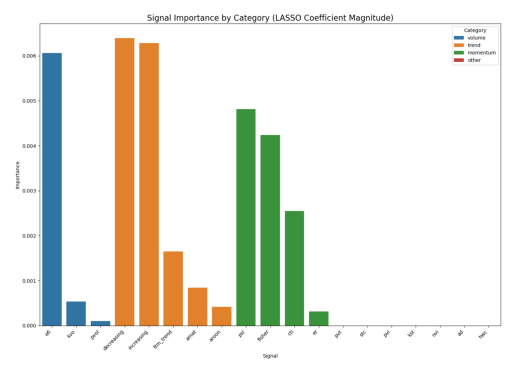

In [128]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("signal_importance_by_category.png")  # Replace "image.png" with your file path
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


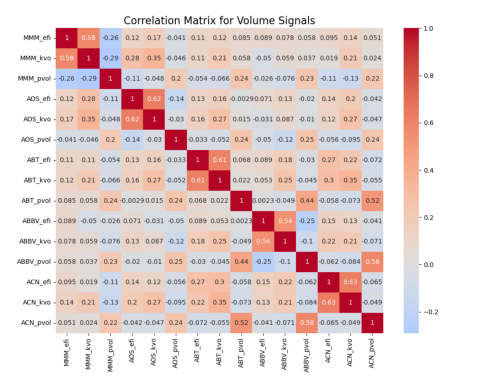

In [130]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("correlation_matrix_volume.png")  # Replace "image.png" with your file path
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


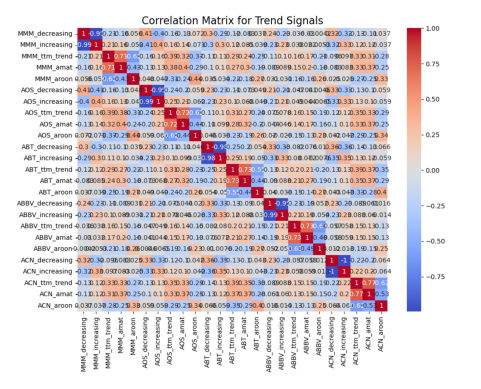

In [132]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("correlation_matrix_trend.png")  # Replace "image.png" with your file path
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


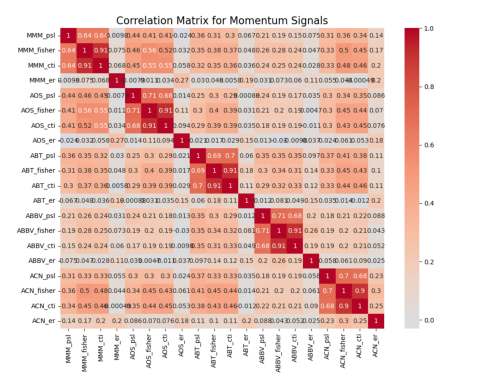

In [136]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("correlation_matrix_momentum.png")  # Replace "image.png" with your file path
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


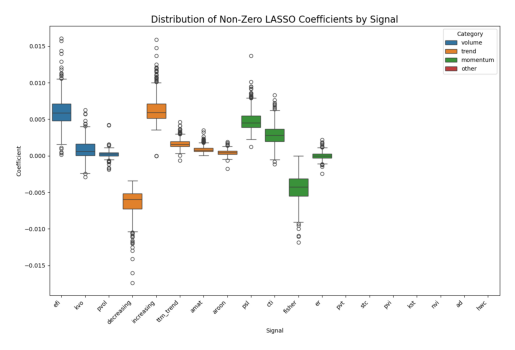

In [140]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread("lasso_coefficient_distribution.png")  # Replace "image.png" with your file path
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()


#### As decrasing is slightly better than increasing and they are almost correlated, will drop increasing

#### As fischer and CTI are almost correlated and fischer is betetr than cti, we will drop cti

### Portfolio Construction - Simple Ranking Portfolio

Starting portfolio backtest for 8 signals
Signals to test: decreasing, efi, psl, fisher, ttm_trend, amat, kvo, aroon
Backtesting portfolio for signal: decreasing
Found 503 tickers with signal decreasing
Found 503 tickers with both signal and returns data
Completed backtest for decreasing
Backtesting portfolio for signal: efi
Found 503 tickers with signal efi
Found 503 tickers with both signal and returns data
Completed backtest for efi
Backtesting portfolio for signal: psl
Found 503 tickers with signal psl
Found 503 tickers with both signal and returns data
Completed backtest for psl
Backtesting portfolio for signal: fisher
Found 503 tickers with signal fisher
Found 503 tickers with both signal and returns data
Completed backtest for fisher
Backtesting portfolio for signal: ttm_trend
Found 503 tickers with signal ttm_trend
Found 503 tickers with both signal and returns data
Completed backtest for ttm_trend
Backtesting portfolio for signal: amat
Found 503 tickers with signal amat
Found 

NameError: name 'long_leverage' is not defined

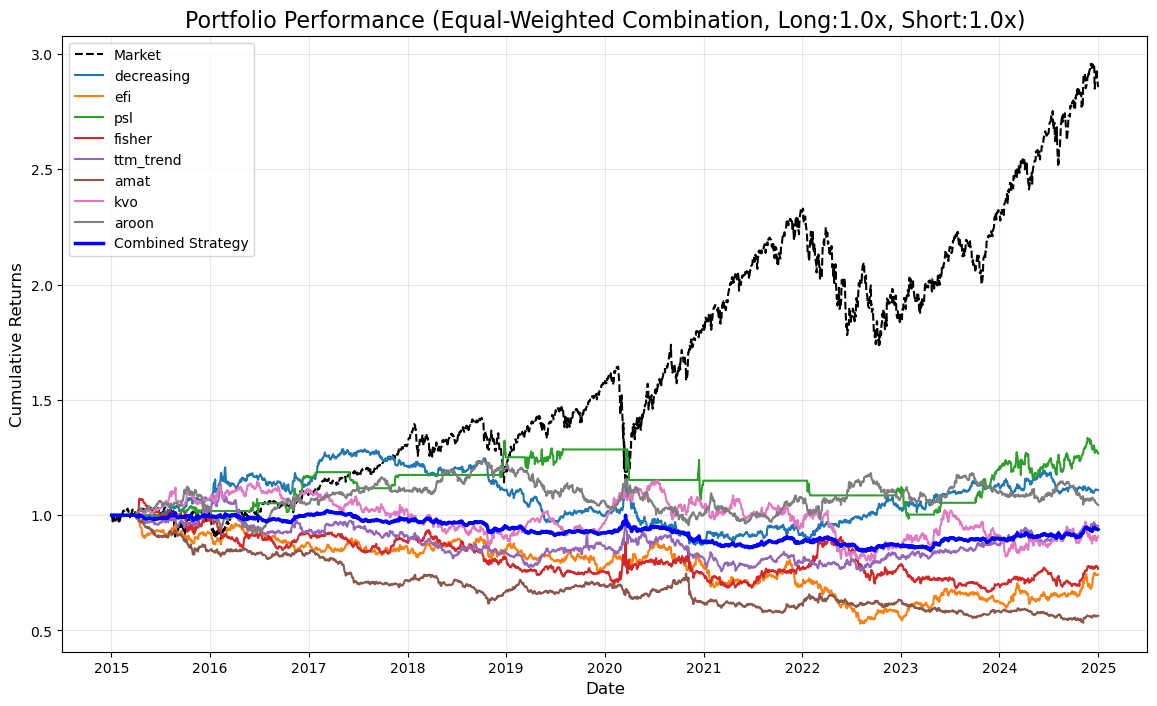

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def calculate_performance_metrics(returns_series, risk_free_rate=0.02/252):
    """
    Calculate key performance metrics for a returns series.
    
    Parameters:
    returns_series: Series with daily returns
    risk_free_rate: Daily risk-free rate (default: 2% annual / 252 trading days)
    
    Returns:
    Dictionary with performance metrics
    """
    # Convert to numpy array for calculations
    returns = returns_series.dropna().values
    
    # Calculate metrics
    total_return = (1 + returns).prod() - 1
    
    # Annualized metrics (assuming 252 trading days)
    trading_days = 252
    n_years = len(returns) / trading_days
    
    # Compound Annual Growth Rate
    cagr = (1 + total_return) ** (1 / n_years) - 1
    
    # Calculate daily excess returns
    excess_returns = returns - risk_free_rate
    
    # Annualized Sharpe Ratio
    sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(trading_days)
    
    # Maximum Drawdown
    cumulative_returns = (1 + pd.Series(returns)).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns / running_max) - 1
    max_drawdown = drawdown.min()
    
    # Volatility (annualized)
    volatility = np.std(returns) * np.sqrt(trading_days)
    
    # Store all metrics
    metrics = {
        'Total Return': total_return,
        'CAGR': cagr,
        'Sharpe Ratio': sharpe_ratio,
        'Max Drawdown': max_drawdown,
        'Volatility': volatility,
        'Information Ratio': None  # Will be filled in later when we have benchmark comparison
    }
    
    return metrics

def backtest_signal_portfolio(combined_df, returns_df, market_returns_df, 
                             signal_name, n_stocks=5, rebalance_freq='M', 
                             lookback_window=1, long_leverage=1.0, short_leverage=1.0):
    """
    Backtest a long-short portfolio strategy based on a single technical indicator.
    
    Parameters:
    combined_df: DataFrame with MultiIndex columns (ticker, indicator)
    returns_df: DataFrame with MultiIndex columns (ticker, field)
    market_returns_df: DataFrame with market returns
    signal_name: Name of the signal to use for ranking
    n_stocks: Number of top/bottom stocks to include in the portfolio
    rebalance_freq: Rebalancing frequency ('M' for monthly, 'W' for weekly)
    lookback_window: Number of periods to look back for signal stability
    
    Returns:
    Dictionary with portfolio returns and performance metrics
    """
    print(f"Backtesting portfolio for signal: {signal_name}")
    
    # Get unique tickers that have this signal
    available_tickers = []
    for ticker in combined_df.columns.get_level_values('ticker').unique():
        try:
            # Check if this ticker has the signal
            combined_df.xs((ticker, signal_name), axis=1)
            available_tickers.append(ticker)
        except:
            continue
    
    print(f"Found {len(available_tickers)} tickers with signal {signal_name}")
    
    # Create a pivoted dataframe for this signal
    signal_values = pd.DataFrame()
    
    for ticker in available_tickers:
        try:
            # Extract signal values for this ticker
            ticker_signal = combined_df.xs((ticker, signal_name), axis=1)
            signal_values[ticker] = ticker_signal
        except Exception as e:
            # print(f"Error extracting signal for {ticker}: {e}")
            continue
    
    # Create a pivoted dataframe for returns
    stock_returns = pd.DataFrame()
    
    for ticker in available_tickers:
        try:
            # Extract returns for this ticker
            ticker_returns = returns_df.xs(ticker, axis=1, level='ticker')
            stock_returns[ticker] = ticker_returns.iloc[:, 0]
        except Exception as e:
            # print(f"Error extracting returns for {ticker}: {e}")
            continue
    
    # Get tickers that have both signals and returns
    common_tickers = list(set(signal_values.columns) & set(stock_returns.columns))
    print(f"Found {len(common_tickers)} tickers with both signal and returns data")
    
    # Keep only tickers with both signal and returns
    signal_values = signal_values[common_tickers]
    stock_returns = stock_returns[common_tickers]
    
    # Define rebalancing dates based on frequency
    if rebalance_freq == 'M':
        rebalance_dates = pd.date_range(start=signal_values.index[0], 
                                        end=signal_values.index[-1], 
                                        freq='M')
    elif rebalance_freq == 'W':
        rebalance_dates = pd.date_range(start=signal_values.index[0], 
                                        end=signal_values.index[-1], 
                                        freq='W-FRI')
    else:
        raise ValueError("Rebalance frequency must be 'M' or 'W'")
    
    # Filter to dates that exist in our data
    rebalance_dates = [date for date in rebalance_dates if date in signal_values.index]
    
    # Initialize portfolio returns
    portfolio_returns = pd.Series(index=stock_returns.index, dtype=float)
    
    # For each rebalancing date
    for i, rebalance_date in enumerate(rebalance_dates):
        if i == len(rebalance_dates) - 1:
            # Skip the last rebalance date (no future returns to calculate)
            continue
            
        next_rebalance_date = rebalance_dates[i + 1]
        
        # Get signal values for current rebalance date
        current_signals = signal_values.loc[rebalance_date].dropna()
        
        # If we don't have enough signals, skip this period
        if len(current_signals) < 2 * n_stocks:
            continue
            
        # Rank stocks by signal value
        ranked_stocks = current_signals.sort_values(ascending=False)
        
        # Get top and bottom n stocks
        top_stocks = ranked_stocks.index[:n_stocks]
        bottom_stocks = ranked_stocks.index[-n_stocks:]
        
        # Get returns for portfolio stocks during this period
        period_mask = (stock_returns.index > rebalance_date) & (stock_returns.index <= next_rebalance_date)
        period_returns = stock_returns.loc[period_mask]
        
        # Skip if no returns in this period
        if period_returns.empty:
            continue
            
        # Calculate portfolio returns (long top stocks, short bottom stocks)
        for date in period_returns.index:
            date_returns = period_returns.loc[date]
            
            # Long returns (equal weight)
            if len(top_stocks) > 0:
                top_returns = date_returns[top_stocks].mean()
            else:
                top_returns = 0
                
            # Short returns (equal weight)
            if len(bottom_stocks) > 0:
                bottom_returns = -date_returns[bottom_stocks].mean()
            else:
                bottom_returns = 0
                
            # Combined long-short returns with leverage
            # Default is equal weight (1:1), but can be adjusted with leverage parameters
            portfolio_returns.loc[date] = (top_returns * long_leverage + bottom_returns * short_leverage) / (long_leverage + short_leverage)
    
    # Fill NaN values in portfolio returns with 0
    portfolio_returns = portfolio_returns.fillna(0)
    
    # Calculate cumulative returns
    portfolio_cumulative_returns = (1 + portfolio_returns).cumprod()
    
    # Get market returns for the same period
    market_returns = market_returns_df.loc[portfolio_returns.index]
    market_cumulative_returns = (1 + market_returns['Market_Returns']).cumprod()
    
    # Calculate performance metrics
    portfolio_metrics = calculate_performance_metrics(portfolio_returns)
    market_metrics = calculate_performance_metrics(market_returns['Market_Returns'])
    
    # Calculate Information Ratio
    excess_returns = portfolio_returns - market_returns['Market_Returns']
    information_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    portfolio_metrics['Information Ratio'] = information_ratio
    
    # Return results
    results = {
        'signal': signal_name,
        'portfolio_returns': portfolio_returns,
        'portfolio_cumulative_returns': portfolio_cumulative_returns,
        'market_returns': market_returns['Market_Returns'],
        'market_cumulative_returns': market_cumulative_returns,
        'portfolio_metrics': portfolio_metrics,
        'market_metrics': market_metrics
    }
    
    return results

def backtest_multiple_signals(combined_df, returns_df, market_returns_df, 
                             signals_list, n_stocks=5, rebalance_freq='M',
                             long_leverage=1.0, short_leverage=1.0):
    """
    Backtest portfolios for multiple signals and compare performance.
    
    Parameters:
    combined_df: DataFrame with MultiIndex columns (ticker, indicator)
    returns_df: DataFrame with MultiIndex columns (ticker, field)
    market_returns_df: DataFrame with market returns
    signals_list: List of signal names to test
    n_stocks: Number of top/bottom stocks to include in each portfolio
    rebalance_freq: Rebalancing frequency ('M' for monthly, 'W' for weekly)
    
    Returns:
    Dictionary with results for all signals
    """
    # Initialize results storage
    all_results = {}
    metrics_summary = pd.DataFrame()
    
    # Backtest each signal
    for signal in signals_list:
        try:
            results = backtest_signal_portfolio(
                combined_df, 
                returns_df, 
                market_returns_df, 
                signal, 
                n_stocks=n_stocks, 
                rebalance_freq=rebalance_freq,
                long_leverage=long_leverage,
                short_leverage=short_leverage
            )
            
            all_results[signal] = results
            
            # Add metrics to summary dataframe
            signal_metrics = pd.Series(results['portfolio_metrics'], name=signal)
            metrics_summary = pd.concat([metrics_summary, signal_metrics.to_frame().T])
            
            print(f"Completed backtest for {signal}")
        except Exception as e:
            print(f"Error backtesting {signal}: {e}")
    
    # Add market metrics to summary
    if all_results:
        market_metrics = pd.Series(all_results[signals_list[0]]['market_metrics'], name='Market')
        metrics_summary = pd.concat([metrics_summary, market_metrics.to_frame().T])
    
    # Return all results
    return {
        'individual_results': all_results,
        'metrics_summary': metrics_summary
    }

def create_combined_strategy(all_results, signals_list, 
                           weighting_method='equal'):
    """
    Create a combined strategy from multiple signal portfolios.
    
    Parameters:
    all_results: Dictionary with results for all signals
    signals_list: List of signal names to include
    weighting_method: Method for weighting signals ('equal', 'sharpe', 'information')
    
    Returns:
    Dictionary with combined strategy results
    """
    print(f"Creating combined strategy using {weighting_method} weighting")
    
    # Get common date range for all portfolios
    common_dates = None
    
    for signal in signals_list:
        if signal not in all_results['individual_results']:
            continue
            
        signal_returns = all_results['individual_results'][signal]['portfolio_returns']
        
        if common_dates is None:
            common_dates = set(signal_returns.index)
        else:
            common_dates = common_dates.intersection(set(signal_returns.index))
    
    common_dates = sorted(list(common_dates))
    
    # Initialize combined returns
    combined_returns = pd.Series(0, index=common_dates)
    
    # Calculate weights based on selected method
    if weighting_method == 'equal':
        # Equal weighting for all signals
        weights = {signal: 1/len(signals_list) for signal in signals_list 
                  if signal in all_results['individual_results']}
    
    elif weighting_method == 'sharpe':
        # Weight by Sharpe Ratio
        metrics = all_results['metrics_summary']
        sharpe_values = metrics.loc[signals_list, 'Sharpe Ratio']
        
        # Handle negative Sharpe ratios by setting to small positive number
        sharpe_values = sharpe_values.apply(lambda x: max(x, 0.0001))
        
        total_sharpe = sharpe_values.sum()
        weights = {signal: sharpe_values[signal]/total_sharpe for signal in signals_list 
                  if signal in all_results['individual_results']}
    
    elif weighting_method == 'information':
        # Weight by Information Ratio
        metrics = all_results['metrics_summary']
        ir_values = metrics.loc[signals_list, 'Information Ratio']
        
        # Handle negative IRs by setting to small positive number
        ir_values = ir_values.apply(lambda x: max(x, 0.0001))
        
        total_ir = ir_values.sum()
        weights = {signal: ir_values[signal]/total_ir for signal in signals_list 
                  if signal in all_results['individual_results']}
    
    # Apply weights to each signal's returns
    for signal, weight in weights.items():
        signal_returns = all_results['individual_results'][signal]['portfolio_returns']
        signal_returns = signal_returns.reindex(common_dates)
        combined_returns += signal_returns * weight
    
    # Calculate cumulative returns
    combined_cumulative_returns = (1 + combined_returns).cumprod()
    
    # Get market returns for the same period
    market_returns = all_results['individual_results'][signals_list[0]]['market_returns']
    market_returns = market_returns.reindex(common_dates)
    market_cumulative_returns = (1 + market_returns).cumprod()
    
    # Calculate performance metrics
    combined_metrics = calculate_performance_metrics(combined_returns)
    
    # Calculate Information Ratio
    excess_returns = combined_returns - market_returns
    information_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    combined_metrics['Information Ratio'] = information_ratio
    
    # Return results
    combined_results = {
        'combined_returns': combined_returns,
        'combined_cumulative_returns': combined_cumulative_returns,
        'market_returns': market_returns,
        'market_cumulative_returns': market_cumulative_returns,
        'combined_metrics': combined_metrics,
        'weights': weights
    }
    
    return combined_results

def plot_strategy_performance(backtest_results, combined_strategy=None, 
                            title="Portfolio Performance", 
                            save_path=None):
    """
    Plot performance of backtest strategies and benchmark.
    
    Parameters:
    backtest_results: Results from backtest_multiple_signals
    combined_strategy: Optional results from combined strategy
    title: Plot title
    save_path: Optional path to save the plot
    """
    plt.figure(figsize=(14, 8))
    
    # Plot individual signals
    first_signal = True
    legend_elements = []
    
    for signal, results in backtest_results['individual_results'].items():
        # Plot cumulative returns
        if first_signal:
            # Only plot market returns once
            plt.plot(results['market_cumulative_returns'], 
                    linestyle='--', color='black', linewidth=1.5)
            legend_elements.append(f"Market")
            first_signal = False
        
        plt.plot(results['portfolio_cumulative_returns'])
        legend_elements.append(f"{signal}")
    
    # Plot combined strategy if provided
    if combined_strategy is not None:
        plt.plot(combined_strategy['combined_cumulative_returns'], 
                linewidth=2.5, color='blue')
        legend_elements.append("Combined Strategy")
    
    plt.legend(legend_elements)
    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Returns', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add text box with performance metrics
    plt.gcf().text(0.02, 0.02, f"Note: Long-short portfolios with top/bottom {n_stocks} stocks (Long:{long_leverage}x, Short:{short_leverage}x)", fontsize=10)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def plot_metrics_comparison(backtest_results, combined_strategy=None,
                          save_path=None):
    """
    Create bar charts comparing key metrics across strategies.
    
    Parameters:
    backtest_results: Results from backtest_multiple_signals
    combined_strategy: Optional results from combined strategy
    save_path: Optional path to save the plot
    """
    metrics = backtest_results['metrics_summary'].copy()
    
    # Add combined strategy if provided
    if combined_strategy is not None:
        combined_metrics = pd.Series(combined_strategy['combined_metrics'], 
                                    name='Combined')
        metrics = pd.concat([metrics, combined_metrics.to_frame().T])
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot CAGR
    metrics['CAGR'].plot(kind='bar', ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Compound Annual Growth Rate (CAGR)', fontsize=14)
    axes[0, 0].set_ylabel('CAGR', fontsize=12)
    axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Plot Sharpe Ratio
    metrics['Sharpe Ratio'].plot(kind='bar', ax=axes[0, 1], color='green')
    axes[0, 1].set_title('Sharpe Ratio', fontsize=14)
    axes[0, 1].set_ylabel('Sharpe Ratio', fontsize=12)
    axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Plot Maximum Drawdown
    metrics['Max Drawdown'].plot(kind='bar', ax=axes[1, 0], color='red')
    axes[1, 0].set_title('Maximum Drawdown', fontsize=14)
    axes[1, 0].set_ylabel('Drawdown', fontsize=12)
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Plot Information Ratio
    metrics['Information Ratio'].plot(kind='bar', ax=axes[1, 1], color='purple')
    axes[1, 1].set_title('Information Ratio vs. Market', fontsize=14)
    axes[1, 1].set_ylabel('Information Ratio', fontsize=12)
    axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return metrics

def run_portfolio_backtest(combined_df, returns_df, market_returns_df, 
                          signals_list, n_stocks=5, rebalance_freq='M',
                          long_leverage=1.0, short_leverage=1.0):
    """
    Run complete portfolio backtest process including combined strategies.
    
    Parameters:
    combined_df: DataFrame with MultiIndex columns (ticker, indicator)
    returns_df: DataFrame with MultiIndex columns (ticker, field)  
    market_returns_df: DataFrame with market returns
    signals_list: List of signal names to test
    n_stocks: Number of top/bottom stocks to include in each portfolio
    rebalance_freq: Rebalancing frequency ('M' for monthly, 'W' for weekly)
    
    Returns:
    Dictionary with all results
    """
    print(f"Starting portfolio backtest for {len(signals_list)} signals")
    print(f"Signals to test: {', '.join(signals_list)}")
    
    # Run backtests for individual signals
    backtest_results = backtest_multiple_signals(
        combined_df, 
        returns_df, 
        market_returns, 
        signals_list, 
        n_stocks=n_stocks, 
        rebalance_freq=rebalance_freq,
        long_leverage=long_leverage,
        short_leverage=short_leverage
    )
    
    # Create combined strategy with equal weights
    combined_equal = create_combined_strategy(
        backtest_results, 
        signals_list, 
        weighting_method='equal'
    )
    
    # Create combined strategy weighted by Sharpe Ratio
    combined_sharpe = create_combined_strategy(
        backtest_results, 
        signals_list, 
        weighting_method='sharpe'
    )
    
    # Plot performance comparison
    plot_strategy_performance(
        backtest_results, 
        combined_strategy=combined_equal,
        title=f"Portfolio Performance (Equal-Weighted Combination, Long:{long_leverage}x, Short:{short_leverage}x)",
        save_path="portfolio_performance_equal.png"
    )
    
    plot_strategy_performance(
        backtest_results, 
        combined_strategy=combined_sharpe,
        title=f"Portfolio Performance (Sharpe-Weighted Combination, Long:{long_leverage}x, Short:{short_leverage}x)",
        save_path="portfolio_performance_sharpe.png"
    )
    
    # Plot metrics comparison
    metrics = plot_metrics_comparison(
        backtest_results, 
        combined_strategy=combined_equal,
        save_path="metrics_comparison.png"
    )
    
    print("\nPerformance Metrics Summary:")
    print(metrics[['CAGR', 'Sharpe Ratio', 'Max Drawdown', 'Information Ratio']])
    
    # Return all results
    results = {
        'individual_results': backtest_results,
        'combined_equal': combined_equal,
        'combined_sharpe': combined_sharpe,
        'metrics_summary': metrics
    }
    
    # Save metrics to CSV
    metrics.to_csv('backtest_metrics_summary.csv')
    print("Metrics summary saved to 'backtest_metrics_summary.csv'")
    
    return results

# Example usage:
if __name__ == "__main__":
    # Define the signals to test based on your results
    signals_to_test = [
        'decreasing',  # trend
        'efi',         # volume
        'psl',         # momentum
        'fisher',      # momentum
        'ttm_trend',   # trend
        'amat',        # trend
        'kvo',         # volume
        'aroon'        # trend
    ]
    
    # Number of top/bottom stocks to include in each portfolio
    n_stocks = 5
    
    # Run the complete backtest
    backtest_results = run_portfolio_backtest(
        combined_df,
        returns_df,
        market_returns,
        signals_to_test,
        n_stocks=n_stocks,
        rebalance_freq='M'  # Monthly rebalancing
    )

Starting portfolio backtest...
Signals being tested: decreasing, efi, psl, fisher, ttm_trend, amat, kvo, aroon
Strategy: Long top 5 (leverage: 3.0x) / Short bottom 5 (leverage: 1.0x) stocks per signal
Starting portfolio backtest for 8 signals
Signals to test: decreasing, efi, psl, fisher, ttm_trend, amat, kvo, aroon
Backtesting portfolio for signal: decreasing
Found 503 tickers with signal decreasing
Found 503 tickers with both signal and returns data
Completed backtest for decreasing
Backtesting portfolio for signal: efi
Found 503 tickers with signal efi
Found 503 tickers with both signal and returns data
Completed backtest for efi
Backtesting portfolio for signal: psl
Found 503 tickers with signal psl
Found 503 tickers with both signal and returns data
Completed backtest for psl
Backtesting portfolio for signal: fisher
Found 503 tickers with signal fisher
Found 503 tickers with both signal and returns data
Completed backtest for fisher
Backtesting portfolio for signal: ttm_trend
Foun

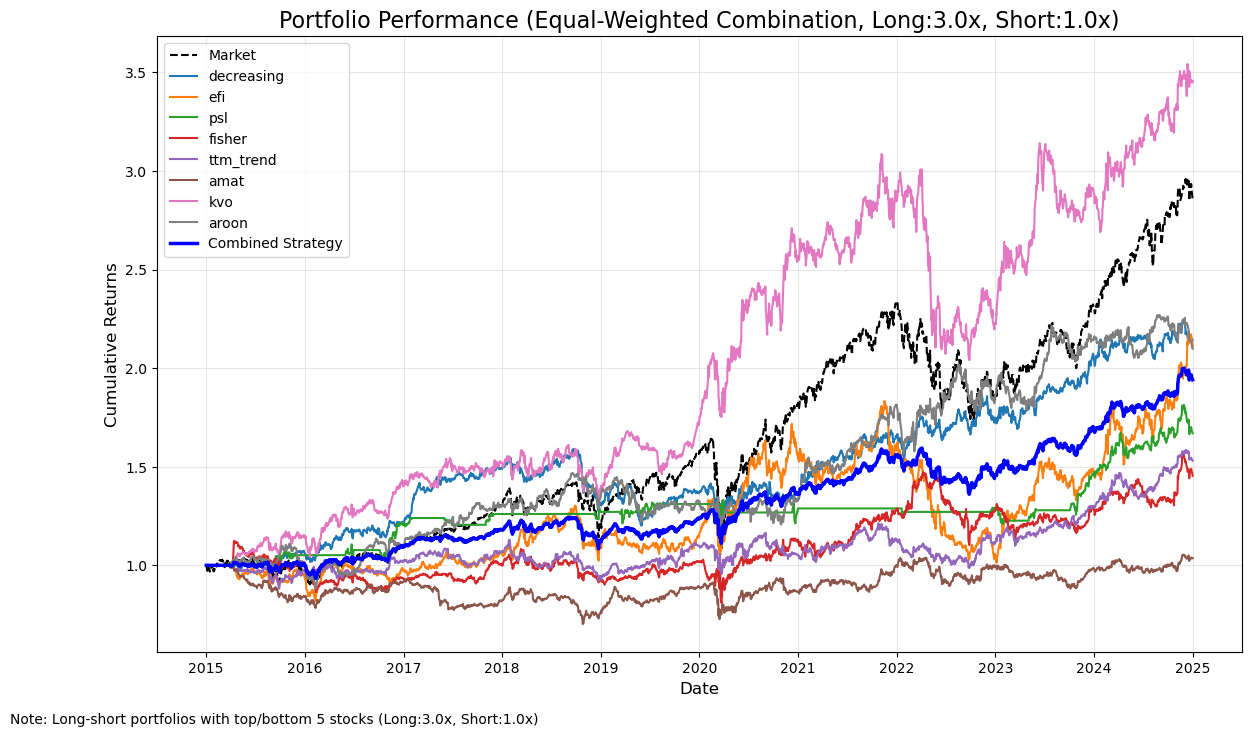

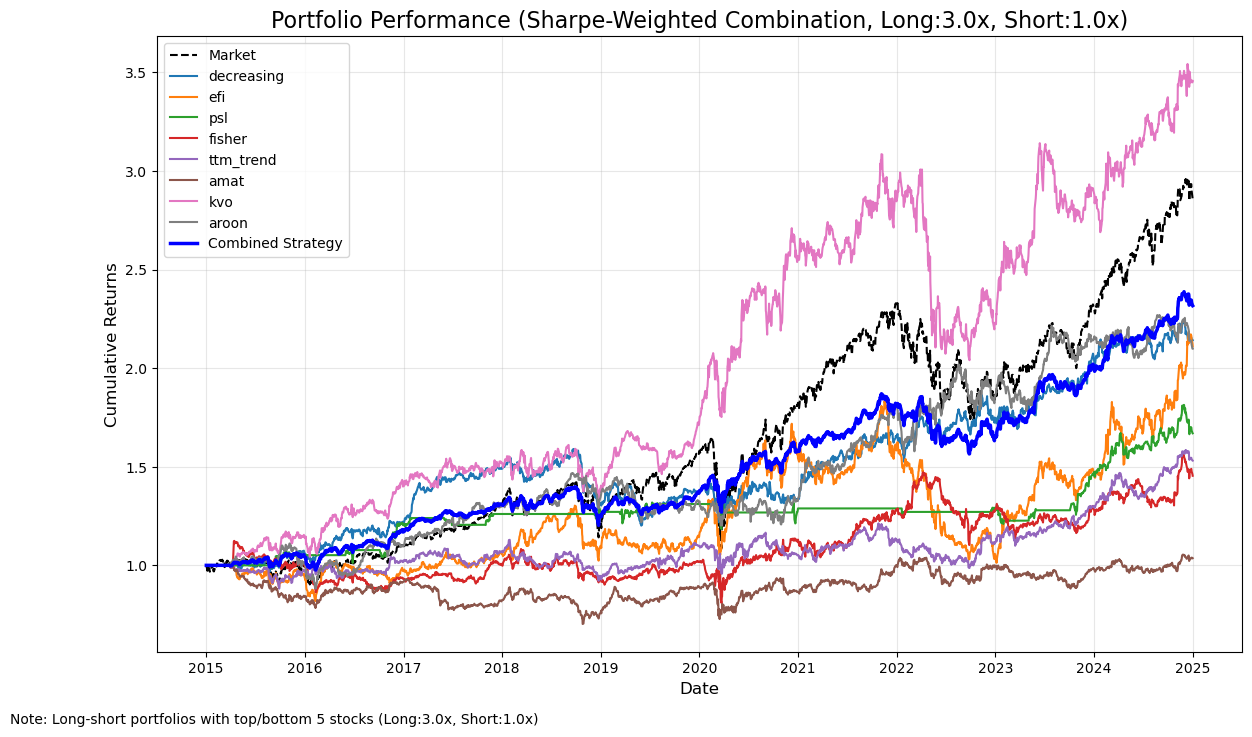

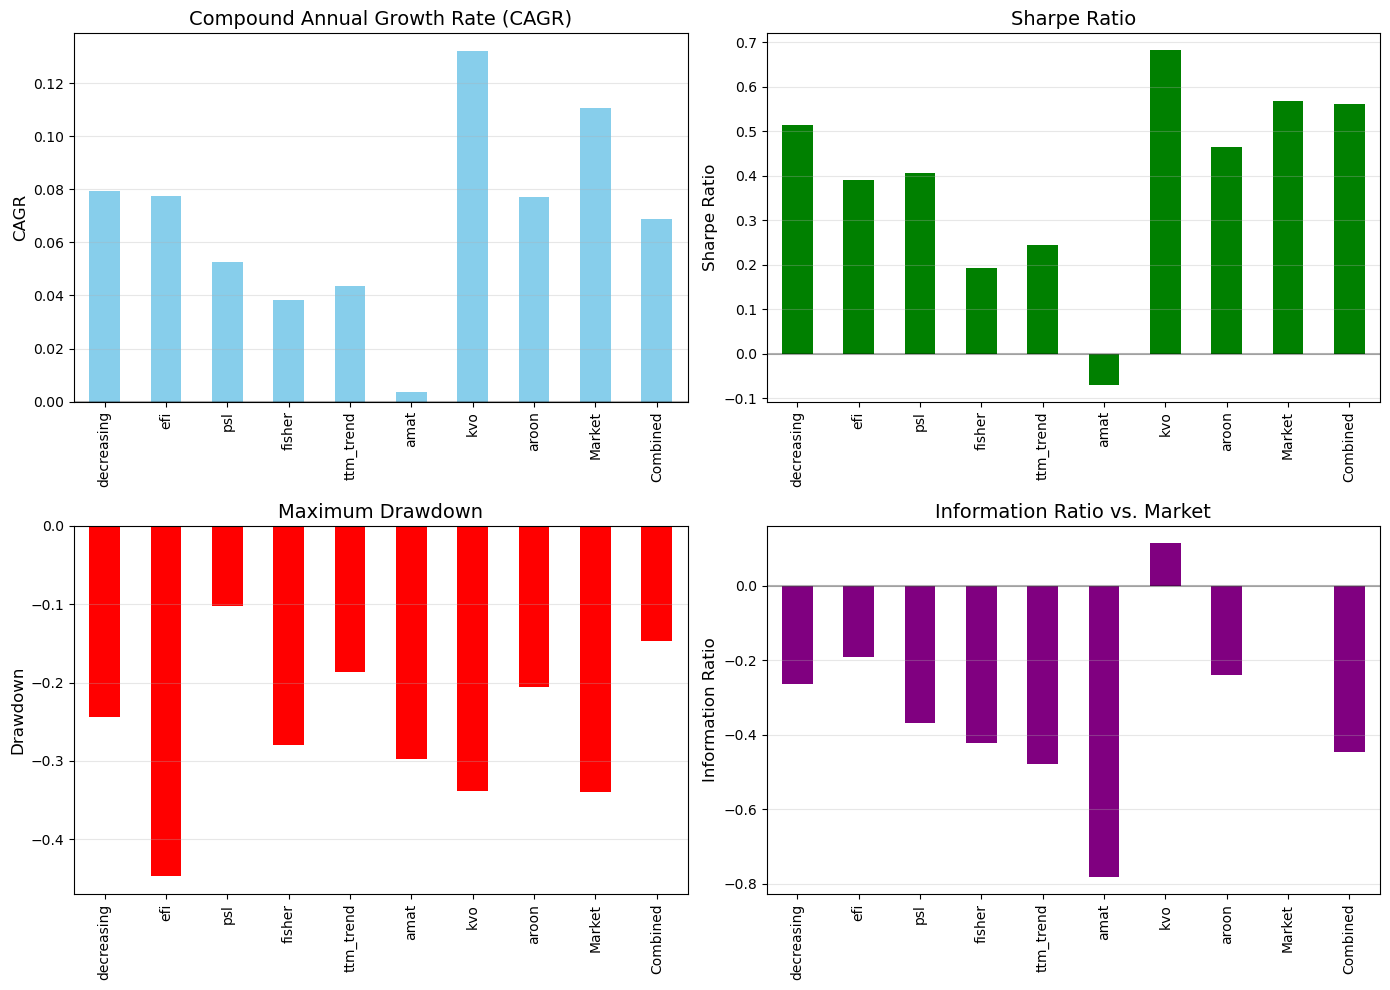


Performance Metrics Summary:
                CAGR  Sharpe Ratio  Max Drawdown  Information Ratio
decreasing  0.079244      0.514368     -0.244467          -0.262955
efi         0.077704      0.390548     -0.447392          -0.190678
psl         0.052682      0.406077     -0.102342          -0.369204
fisher      0.038218      0.192401     -0.279877          -0.422839
ttm_trend   0.043581      0.244963     -0.186771          -0.477837
amat        0.003578     -0.069239     -0.297428          -0.782698
kvo         0.132271      0.682140     -0.338663           0.115992
aroon       0.077072      0.464168     -0.205884          -0.238707
Market      0.110858      0.567356     -0.339250                NaN
Combined    0.068687      0.560018     -0.146955          -0.445097
Metrics summary saved to 'backtest_metrics_summary.csv'

Backtest Complete!
The results have been saved to CSV files and performance charts have been generated.


In [65]:
import pandas as pd
import numpy as np

# Define the signals to test based on your results
signals_to_test = [
    'decreasing',  # trend
    'efi',         # volume
    'psl',         # momentum
    'fisher',      # momentum
    'ttm_trend',   # trend
    'amat',        # trend
    'kvo',         # volume
    'aroon'        # trend
]

# Number of top/bottom stocks to include in each portfolio
n_stocks = 5

# Set leverage for long and short positions
long_leverage = 3.0  # 2x leverage on long side
short_leverage = 1.0  # 2x leverage on short side

# Make sure your data is already loaded
# combined_df - your signals dataframe with MultiIndex columns (ticker, indicator)
# returns_df - your returns dataframe with MultiIndex columns (ticker, field)
# market_returns_df - your market returns with 'Market_Returns' column

print("Starting portfolio backtest...")
print(f"Signals being tested: {', '.join(signals_to_test)}")
print(f"Strategy: Long top {n_stocks} (leverage: {long_leverage}x) / Short bottom {n_stocks} (leverage: {short_leverage}x) stocks per signal")

# Run the complete backtest
backtest_results = run_portfolio_backtest(
    combined_df,
    returns_df,
    market_returns,
    signals_to_test,
    n_stocks=n_stocks,
    rebalance_freq='M',  # Monthly rebalancing
    long_leverage=long_leverage,
    short_leverage=short_leverage
)

print("\nBacktest Complete!")
print("The results have been saved to CSV files and performance charts have been generated.")

Starting leverage optimization...
Testing leverage combination: Long=1.0x, Short=1.0x (1/25)
Backtesting portfolio for signal: decreasing
Found 503 tickers with signal decreasing
Found 503 tickers with both signal and returns data
Completed backtest for decreasing
Backtesting portfolio for signal: efi
Found 503 tickers with signal efi
Found 503 tickers with both signal and returns data
Completed backtest for efi
Backtesting portfolio for signal: psl
Found 503 tickers with signal psl
Found 503 tickers with both signal and returns data
Completed backtest for psl
Backtesting portfolio for signal: fisher
Found 503 tickers with signal fisher
Found 503 tickers with both signal and returns data
Completed backtest for fisher
Backtesting portfolio for signal: ttm_trend
Found 503 tickers with signal ttm_trend
Found 503 tickers with both signal and returns data
Completed backtest for ttm_trend
Backtesting portfolio for signal: amat
Found 503 tickers with signal amat
Found 503 tickers with both si

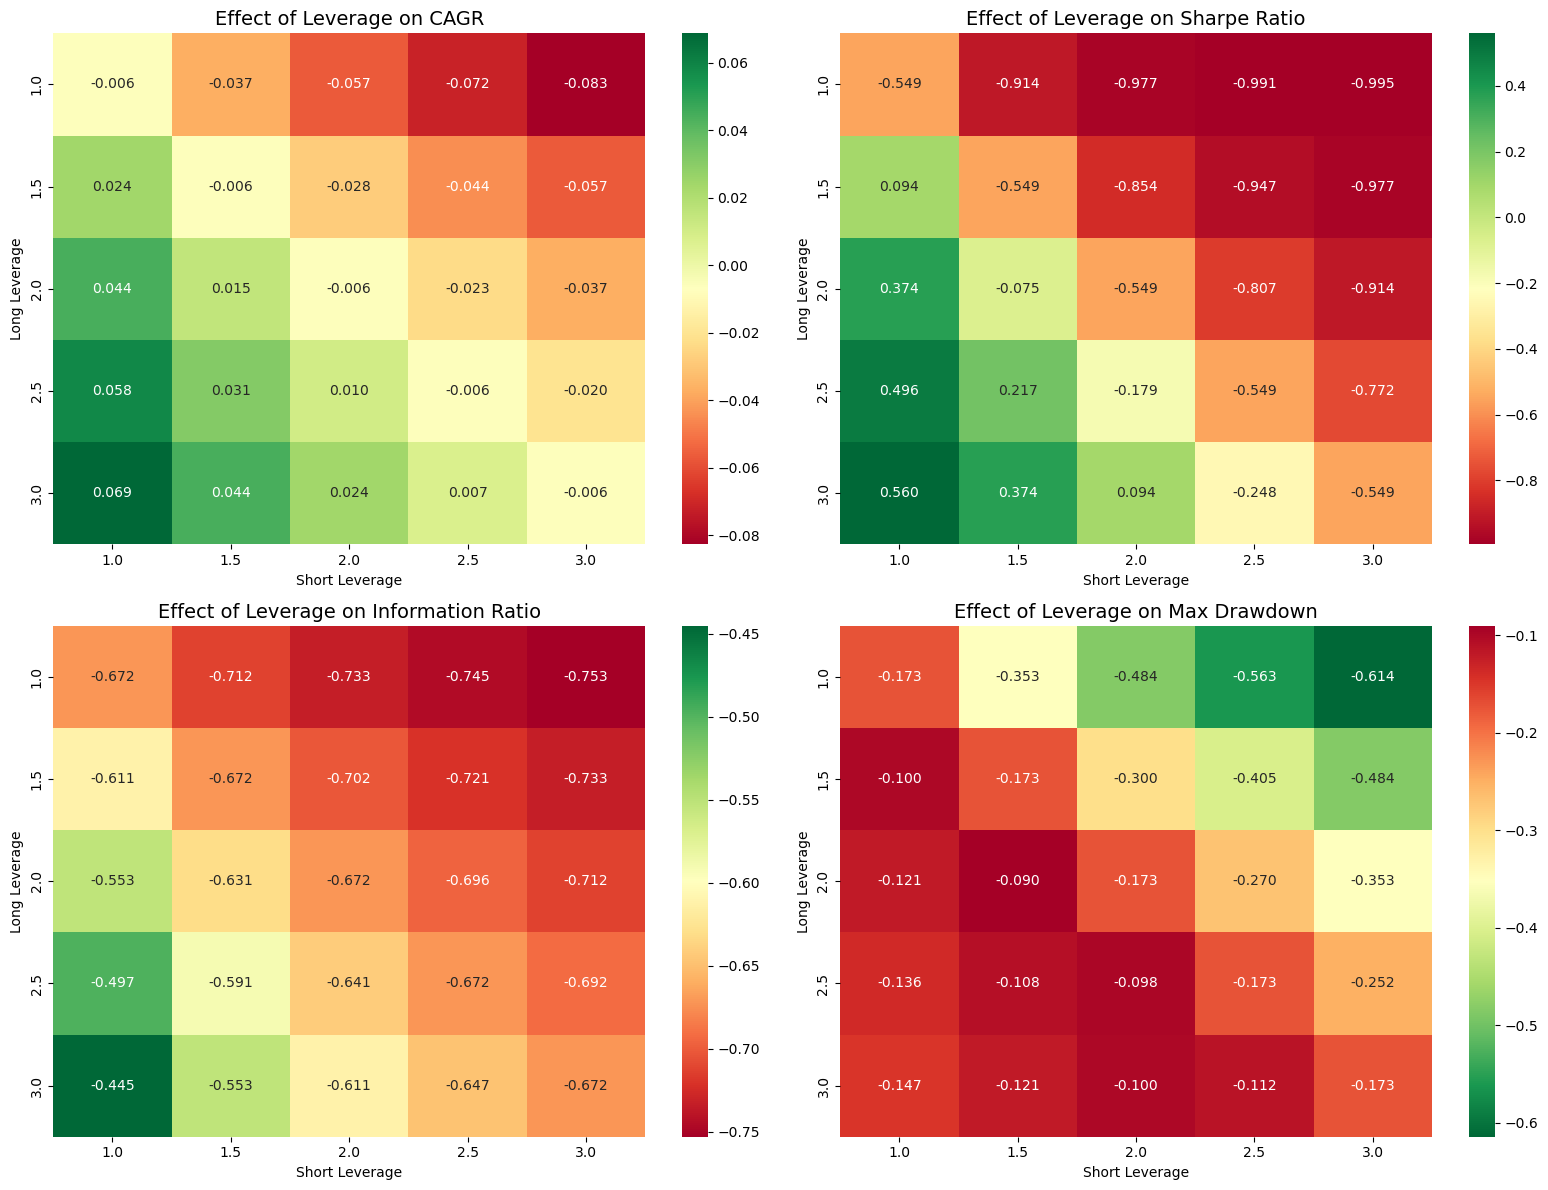

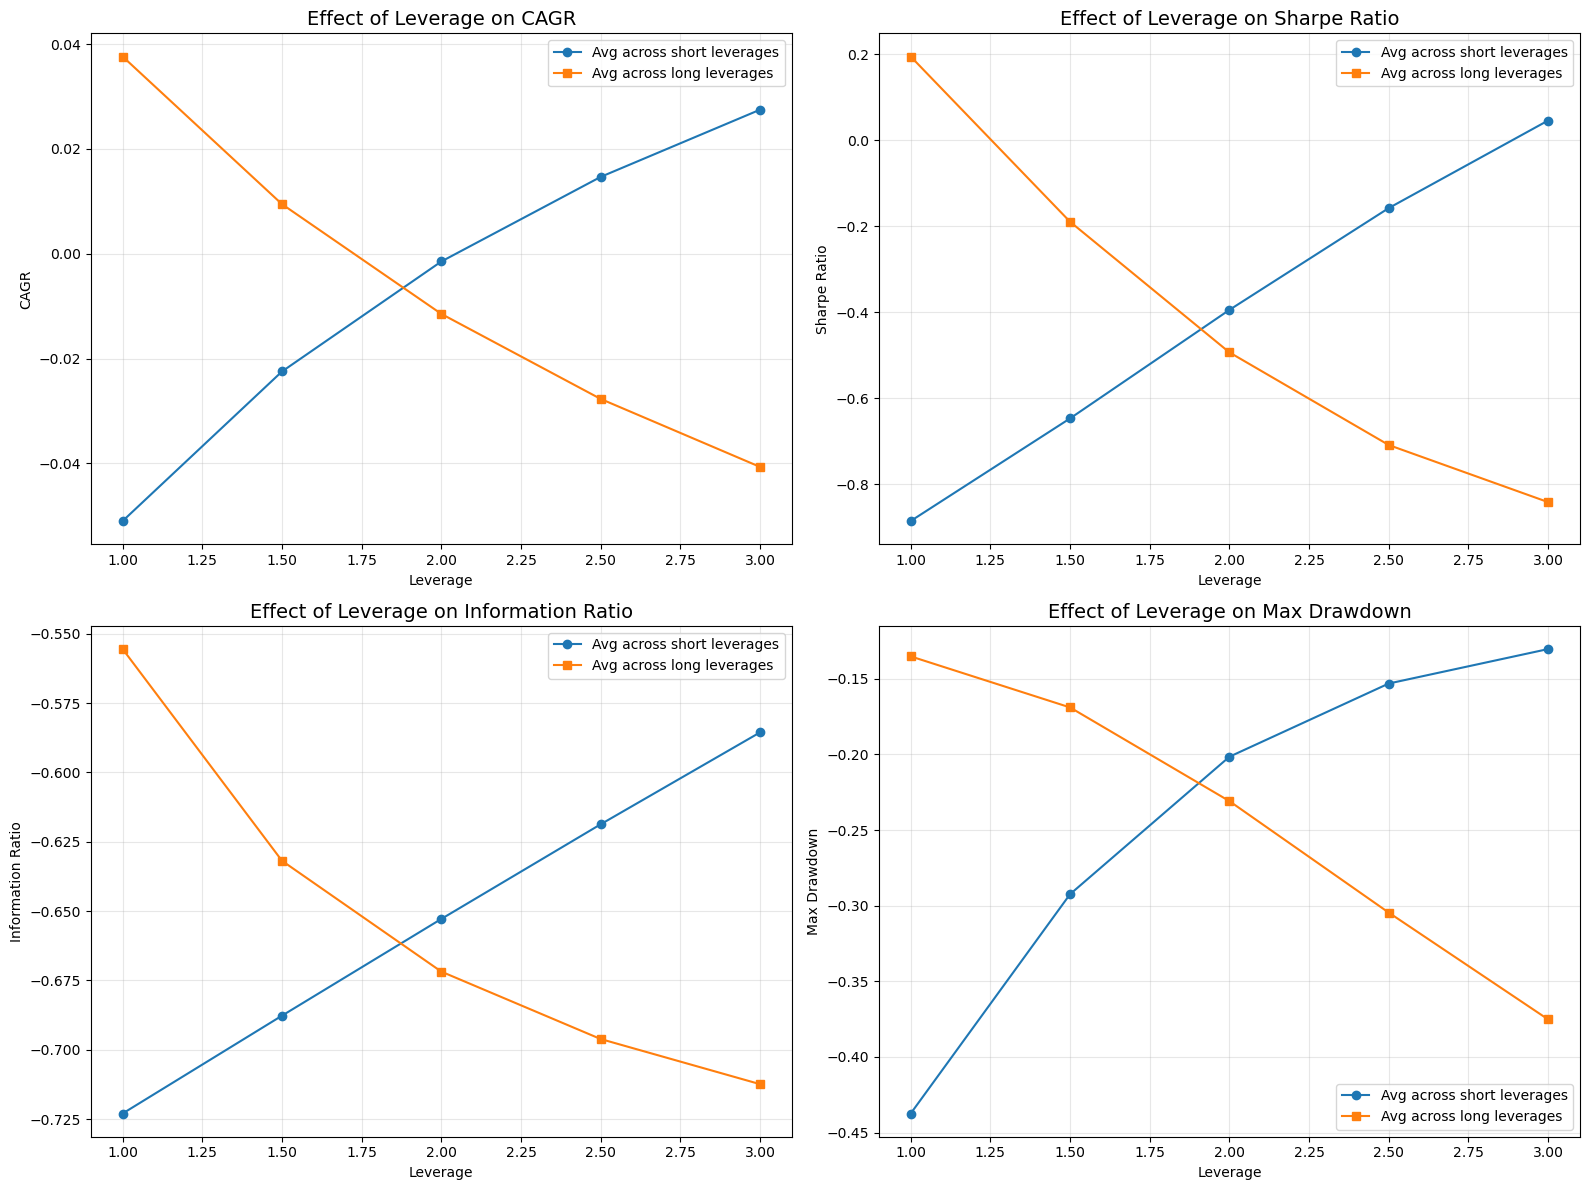


Optimal leverage settings based on Sharpe_Ratio:
Long Leverage: 3.0x
Short Leverage: 1.0x

Performance metrics with optimal leverage:
CAGR: 0.0687
Sharpe Ratio: 0.5600
Max Drawdown: -0.1470
Information Ratio: -0.4451

Recommendation:
For best overall performance, use long leverage of 3.0x and short leverage of 1.0x


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
def optimize_leverage(combined_df, returns_df, market_returns_df, signals_list, n_stocks=5):
    """
    Explore different leverage settings to optimize portfolio performance.
    
    Parameters:
    combined_df: DataFrame with MultiIndex columns (ticker, indicator)
    returns_df: DataFrame with MultiIndex columns (ticker, field)
    market_returns_df: DataFrame with market returns
    signals_list: List of signal names to test
    n_stocks: Number of top/bottom stocks to include in each portfolio
    
    Returns:
    DataFrame with results for different leverage settings
    """
    print("Starting leverage optimization...")
    
    # Define leverage settings to test
    long_leverages = [1.0, 1.5, 2.0, 2.5, 3.0]
    short_leverages = [1.0, 1.5, 2.0, 2.5, 3.0]
    
    # Initialize results storage
    results_summary = pd.DataFrame(
        columns=['Long_Leverage', 'Short_Leverage', 'CAGR', 'Sharpe_Ratio', 
                'Max_Drawdown', 'Information_Ratio']
    )
    
    row_idx = 0
    total_tests = len(long_leverages) * len(short_leverages)
    
    # Test each leverage combination
    for long_lev in long_leverages:
        for short_lev in short_leverages:
            print(f"Testing leverage combination: Long={long_lev}x, Short={short_lev}x ({row_idx+1}/{total_tests})")
            
            # Run backtest for this leverage setting
            backtest_results = backtest_multiple_signals(
                combined_df, 
                returns_df, 
                market_returns, 
                signals_list, 
                n_stocks=n_stocks, 
                rebalance_freq='M',
                long_leverage=long_lev,
                short_leverage=short_lev
            )
            
            # Create combined strategy with equal weights
            combined_strategy = create_combined_strategy(
                backtest_results, 
                signals_list, 
                weighting_method='equal'
            )
            
            # Extract performance metrics
            metrics = combined_strategy['combined_metrics']
            
            # Add to results summary
            results_summary.loc[row_idx] = [
                long_lev,
                short_lev,
                metrics['CAGR'],
                metrics['Sharpe Ratio'],
                metrics['Max Drawdown'],
                metrics['Information Ratio']
            ]
            
            row_idx += 1
    
    # Save results to CSV
    results_summary.to_csv('leverage_optimization_results.csv', index=False)
    print("Leverage optimization results saved to 'leverage_optimization_results.csv'")
    
    # Plot results
    plot_leverage_optimization(results_summary)
    
    return results_summary

def plot_leverage_optimization(results):
    """
    Plot heatmaps showing how different leverage settings affect performance.
    
    Parameters:
    results: DataFrame with results from optimize_leverage
    """
    metrics = ['CAGR', 'Sharpe_Ratio', 'Information_Ratio', 'Max_Drawdown']
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        # Create pivot table for heatmap
        pivot = results.pivot(index='Long_Leverage', columns='Short_Leverage', values=metric)
        
        # Determine colormap (different for drawdown)
        cmap = 'RdYlGn_r' if metric == 'Max_Drawdown' else 'RdYlGn'
        
        # Plot heatmap
        sns.heatmap(pivot, annot=True, cmap=cmap, ax=axes[i], fmt='.3f')
        axes[i].set_title(f'Effect of Leverage on {metric.replace("_", " ")}', fontsize=14)
        axes[i].set_xlabel('Short Leverage')
        axes[i].set_ylabel('Long Leverage')
    
    plt.tight_layout()
    plt.savefig('leverage_optimization_heatmaps.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Create line plots showing trends
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for i, metric in enumerate(metrics):
        # Group by long leverage and plot average across short leverages
        long_avg = results.groupby('Long_Leverage')[metric].mean()
        axes[i].plot(long_avg.index, long_avg.values, 'o-', label='Avg across short leverages')
        
        # Group by short leverage and plot average across long leverages
        short_avg = results.groupby('Short_Leverage')[metric].mean()
        axes[i].plot(short_avg.index, short_avg.values, 's-', label='Avg across long leverages')
        
        axes[i].set_title(f'Effect of Leverage on {metric.replace("_", " ")}', fontsize=14)
        axes[i].set_xlabel('Leverage')
        axes[i].set_ylabel(metric.replace("_", " "))
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    
    plt.tight_layout()
    plt.savefig('leverage_optimization_trends.png', dpi=300, bbox_inches='tight')
    plt.show()

def find_optimal_leverage(results, priority_metric='Sharpe_Ratio'):
    """
    Find optimal leverage settings based on specified metric.
    
    Parameters:
    results: DataFrame with results from optimize_leverage
    priority_metric: Metric to prioritize for optimization
    
    Returns:
    Dictionary with optimal leverage settings
    """
    # Special handling for drawdown (lower is better)
    if priority_metric == 'Max_Drawdown':
        optimal_idx = results['Max_Drawdown'].idxmax()
    else:
        optimal_idx = results[priority_metric].idxmax()
    
    optimal_row = results.iloc[optimal_idx]
    
    # Display optimal results
    print(f"\nOptimal leverage settings based on {priority_metric}:")
    print(f"Long Leverage: {optimal_row['Long_Leverage']}x")
    print(f"Short Leverage: {optimal_row['Short_Leverage']}x")
    print("\nPerformance metrics with optimal leverage:")
    print(f"CAGR: {optimal_row['CAGR']:.4f}")
    print(f"Sharpe Ratio: {optimal_row['Sharpe_Ratio']:.4f}")
    print(f"Max Drawdown: {optimal_row['Max_Drawdown']:.4f}")
    print(f"Information Ratio: {optimal_row['Information_Ratio']:.4f}")
    
    return {
        'long_leverage': optimal_row['Long_Leverage'],
        'short_leverage': optimal_row['Short_Leverage'],
        'metrics': {
            'CAGR': optimal_row['CAGR'],
            'Sharpe_Ratio': optimal_row['Sharpe_Ratio'],
            'Max_Drawdown': optimal_row['Max_Drawdown'],
            'Information_Ratio': optimal_row['Information_Ratio']
        }
    }

# Example usage
if __name__ == "__main__":
    # Define the signals to test
    signals_to_test = [
        'decreasing',  # trend
        'efi',         # volume
        'psl',         # momentum
        'fisher',      # momentum
        'ttm_trend',   # trend
        'amat',        # trend
        'kvo',         # volume
        'aroon'        # trend
    ]
    
    # Run leverage optimization
    leverage_results = optimize_leverage(
        combined_df,
        returns_df,
        market_returns,
        signals_to_test,
        n_stocks=5
    )
    
    # Find optimal leverage settings
    optimal_settings = find_optimal_leverage(leverage_results, priority_metric='Sharpe_Ratio')
    
    # Print recommendation
    print("\nRecommendation:")
    print(f"For best overall performance, use long leverage of {optimal_settings['long_leverage']}x and short leverage of {optimal_settings['short_leverage']}x")

### Portfolio Construction - Volatility targeting

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

def calculate_rolling_volatility(returns_df, window=63, min_periods=20):
    """
    Calculate rolling volatility for each stock based on returns.
    
    Parameters:
    returns_df: DataFrame with stock returns (columns are tickers)
    window: Rolling window size (default: 63 days ~ 3 months)
    min_periods: Minimum number of observations required for calculation
    
    Returns:
    DataFrame with rolling volatility for each stock
    """
    # Initialize volatility dataframe
    volatility_df = pd.DataFrame(index=returns_df.index)
    
    # Calculate rolling standard deviation for each stock
    for ticker in returns_df.columns:
        volatility_df[ticker] = returns_df[ticker].rolling(window=window, min_periods=min_periods).std() * np.sqrt(252)  # Annualized
    
    # Forward fill NaN values (use most recent volatility)
    volatility_df = volatility_df.fillna(method='ffill')
    
    # Fill any remaining NaN with median volatility for each ticker
    for ticker in volatility_df.columns:
        ticker_vol = volatility_df[ticker]
        median_vol = ticker_vol.median()
        if not np.isnan(median_vol):
            volatility_df[ticker] = ticker_vol.fillna(median_vol)
        else:
            # If median is NaN, use market median volatility
            market_median = volatility_df.median().median()
            volatility_df[ticker] = ticker_vol.fillna(market_median)
    
    return volatility_df

def calculate_performance_metrics(returns_series, risk_free_rate=0.02/252):
    """
    Calculate key performance metrics for a returns series.
    
    Parameters:
    returns_series: Series with daily returns
    risk_free_rate: Daily risk-free rate (default: 2% annual / 252 trading days)
    
    Returns:
    Dictionary with performance metrics
    """
    # Convert to numpy array for calculations
    returns = returns_series.dropna().values
    
    if len(returns) == 0:
        return {
            'Total Return': 0,
            'CAGR': 0,
            'Sharpe Ratio': 0,
            'Sortino Ratio': 0,
            'Max Drawdown': 0,
            'Volatility': 0,
            'Information Ratio': None
        }
    
    # Calculate metrics
    total_return = (1 + returns).prod() - 1
    
    # Annualized metrics (assuming 252 trading days)
    trading_days = 252
    n_years = len(returns) / trading_days
    
    # Compound Annual Growth Rate
    cagr = (1 + total_return) ** (1 / n_years) - 1
    
    # Calculate daily excess returns
    excess_returns = returns - risk_free_rate
    
    # Annualized Sharpe Ratio
    volatility = np.std(returns) * np.sqrt(trading_days)
    if volatility > 0:
        sharpe_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(trading_days)
    else:
        sharpe_ratio = 0
    
    # Maximum Drawdown
    cumulative_returns = (1 + pd.Series(returns)).cumprod()
    running_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns / running_max) - 1
    max_drawdown = drawdown.min()
    
    # Sortino Ratio (only considers downside deviation)
    downside_returns = np.minimum(excess_returns - np.mean(excess_returns), 0)
    downside_deviation = np.sqrt(np.mean(downside_returns**2)) * np.sqrt(trading_days)
    sortino_ratio = np.mean(excess_returns) * np.sqrt(trading_days) / downside_deviation if downside_deviation != 0 else 0
    
    # Store all metrics
    metrics = {
        'Total Return': total_return,
        'CAGR': cagr,
        'Sharpe Ratio': sharpe_ratio,
        'Sortino Ratio': sortino_ratio,
        'Max Drawdown': max_drawdown,
        'Volatility': volatility,
        'Information Ratio': None  # Will be filled in later when we have benchmark comparison
    }
    
    return metrics

def backtest_enhanced_volatility_targeting(combined_df, returns_df, market_returns_df, 
                                         signal_name, n_stocks=5, rebalance_freq='M',
                                         target_volatility=0.15, volatility_window=42,
                                         min_periods=20, max_leverage=3.0, 
                                         min_leverage=0.5, long_leverage=2.0, 
                                         short_leverage=2.0, signal_threshold=None):
    """
    Backtest an enhanced portfolio strategy with volatility targeting.
    
    Parameters:
    combined_df: DataFrame with MultiIndex columns (ticker, indicator)
    returns_df: DataFrame with MultiIndex columns (ticker, field)
    market_returns_df: DataFrame with market returns
    signal_name: Name of the signal to use for ranking
    n_stocks: Number of top/bottom stocks to include in the portfolio
    rebalance_freq: Rebalancing frequency ('M' for monthly, 'W' for weekly)
    target_volatility: Target portfolio volatility (annualized)
    volatility_window: Window size for volatility calculation
    min_periods: Minimum number of observations required for volatility calculation
    max_leverage: Maximum allowed leverage for any single position
    min_leverage: Minimum allowed leverage for any single position
    long_leverage: Base leverage for long positions
    short_leverage: Base leverage for short positions
    signal_threshold: Optional threshold for signal strength
    
    Returns:
    Dictionary with portfolio returns and performance metrics
    """
    print(f"Backtesting enhanced volatility targeting portfolio for signal: {signal_name}")
    
    # Get unique tickers that have this signal
    available_tickers = []
    for ticker in combined_df.columns.get_level_values('ticker').unique():
        try:
            # Check if this ticker has the signal
            combined_df.xs((ticker, signal_name), axis=1)
            available_tickers.append(ticker)
        except:
            continue
    
    print(f"Found {len(available_tickers)} tickers with signal {signal_name}")
    
    # Create a pivoted dataframe for this signal
    signal_values = pd.DataFrame()
    
    for ticker in available_tickers:
        try:
            # Extract signal values for this ticker
            ticker_signal = combined_df.xs((ticker, signal_name), axis=1)
            signal_values[ticker] = ticker_signal
        except Exception as e:
            continue
    
    # Create a pivoted dataframe for returns
    stock_returns = pd.DataFrame()
    
    for ticker in available_tickers:
        try:
            # Extract returns for this ticker
            ticker_returns = returns_df.xs(ticker, axis=1, level='ticker')
            stock_returns[ticker] = ticker_returns.iloc[:, 0]
        except Exception as e:
            continue
    
    # Get tickers that have both signals and returns
    common_tickers = list(set(signal_values.columns) & set(stock_returns.columns))
    print(f"Found {len(common_tickers)} tickers with both signal and returns data")
    
    # Keep only tickers with both signal and returns
    signal_values = signal_values[common_tickers]
    stock_returns = stock_returns[common_tickers]
    
    # Calculate rolling volatility for each stock with enhanced handling
    print("Calculating rolling volatility...")
    volatility_df = calculate_rolling_volatility(stock_returns, window=volatility_window, min_periods=min_periods)
    
    # Calculate market volatility (for normalization)
    market_returns = market_returns_df['Market_Returns']
    market_volatility = market_returns.rolling(window=volatility_window, min_periods=min_periods).std() * np.sqrt(252)
    market_volatility = market_volatility.fillna(method='ffill')
    
    # Relative volatility (stock vol / market vol) - useful for filtering extreme stocks
    relative_volatility = pd.DataFrame(index=volatility_df.index)
    for ticker in volatility_df.columns:
        relative_volatility[ticker] = volatility_df[ticker] / market_volatility
    
    # Define rebalancing dates based on frequency
    if rebalance_freq == 'M':
        rebalance_dates = pd.date_range(start=signal_values.index[0], 
                                        end=signal_values.index[-1], 
                                        freq='M')
    elif rebalance_freq == 'W':
        rebalance_dates = pd.date_range(start=signal_values.index[0], 
                                        end=signal_values.index[-1], 
                                        freq='W-FRI')
    else:
        raise ValueError("Rebalance frequency must be 'M' or 'W'")
    
    # Filter to dates that exist in our data
    rebalance_dates = [date for date in rebalance_dates if date in signal_values.index]
    
    # Skip first few rebalance dates if we don't have enough data for volatility calculation
    start_idx = volatility_window // 20  # Rough estimate to ensure we have volatility data
    if start_idx >= len(rebalance_dates):
        start_idx = 0
    
    # Initialize portfolio returns
    portfolio_returns = pd.Series(index=stock_returns.index, dtype=float)
    
    # Keep track of positions for analysis
    positions_history = {}
    
    # For each rebalancing date
    for i, rebalance_date in enumerate(rebalance_dates[start_idx:]):
        i = i + start_idx  # Adjust index for the actual rebalance_dates list
        
        if i == len(rebalance_dates) - 1:
            # Skip the last rebalance date (no future returns to calculate)
            continue
            
        next_rebalance_date = rebalance_dates[i + 1]
        
        # Get signal values for current rebalance date
        current_signals = signal_values.loc[rebalance_date].dropna()
        
        # If signal threshold is provided, filter signals
        if signal_threshold is not None:
            # For long positions, keep only stocks with signal > threshold
            top_signals = current_signals[current_signals > signal_threshold]
            
            # For short positions, keep only stocks with signal < -threshold
            bottom_signals = current_signals[current_signals < -signal_threshold]
            
            # If not enough stocks, use top/bottom n
            if len(top_signals) < n_stocks or len(bottom_signals) < n_stocks:
                # Rank stocks by signal value
                ranked_stocks = current_signals.sort_values(ascending=False)
                
                # Get top and bottom n stocks
                top_stocks = ranked_stocks.index[:n_stocks]
                bottom_stocks = ranked_stocks.index[-n_stocks:]
            else:
                # Use the thresholded stocks
                top_stocks = top_signals.index
                bottom_stocks = bottom_signals.index
        else:
            # If not enough signals, skip this period
            if len(current_signals) < 2 * n_stocks:
                continue
                
            # Rank stocks by signal value
            ranked_stocks = current_signals.sort_values(ascending=False)
            
            # Get top and bottom n stocks
            top_stocks = ranked_stocks.index[:n_stocks]
            bottom_stocks = ranked_stocks.index[-n_stocks:]
        
        # Get current volatility for selected stocks
        current_volatility = volatility_df.loc[rebalance_date]
        current_rel_vol = relative_volatility.loc[rebalance_date]
        
        # Filter out extremely volatile stocks (relative to market)
        max_rel_vol = 2.5  # Stocks more than 2.5x market volatility will be excluded
        
        filtered_top_stocks = [ticker for ticker in top_stocks 
                              if ticker in current_rel_vol.index and 
                              current_rel_vol[ticker] <= max_rel_vol]
        
        filtered_bottom_stocks = [ticker for ticker in bottom_stocks 
                                if ticker in current_rel_vol.index and 
                                current_rel_vol[ticker] <= max_rel_vol]
        
        # If too many stocks filtered out, revert to original selection
        if len(filtered_top_stocks) < min(2, len(top_stocks)):
            filtered_top_stocks = list(top_stocks)
        if len(filtered_bottom_stocks) < min(2, len(bottom_stocks)):
            filtered_bottom_stocks = list(bottom_stocks)
        
        # Update stocks lists with filtered versions
        top_stocks = filtered_top_stocks
        bottom_stocks = filtered_bottom_stocks
        
        # Calculate volatility scaling factor for each stock
        # Higher volatility -> lower position size, and vice versa
        scaling_factors = {}
        
        for ticker in list(top_stocks) + list(bottom_stocks):
            if ticker in current_volatility.index and not np.isnan(current_volatility[ticker]) and current_volatility[ticker] > 0:
                # Calculate scaling factor
                scaling_factor = target_volatility / current_volatility[ticker]
                
                # Apply limits to scaling factor
                scaling_factor = min(max(scaling_factor, min_leverage), max_leverage)
                
                scaling_factors[ticker] = scaling_factor
            else:
                # Default to 1.0 if volatility is not available
                scaling_factors[ticker] = 1.0
        
        # Get returns for portfolio stocks during this period
        period_mask = (stock_returns.index > rebalance_date) & (stock_returns.index <= next_rebalance_date)
        period_returns = stock_returns.loc[period_mask]
        
        # Skip if no returns in this period
        if period_returns.empty:
            continue
        
        # Store positions for this rebalancing period
        positions = {
            'date': rebalance_date,
            'long_stocks': list(top_stocks),
            'short_stocks': list(bottom_stocks),
            'long_scaling': {t: scaling_factors.get(t, 1.0) for t in top_stocks},
            'short_scaling': {t: scaling_factors.get(t, 1.0) for t in bottom_stocks}
        }
        positions_history[rebalance_date] = positions
            
        # Calculate portfolio returns with enhanced volatility targeting
        for date in period_returns.index:
            date_returns = period_returns.loc[date]
            
            # Long returns (volatility-weighted)
            top_weighted_returns = 0
            total_long_weight = 0
            
            for ticker in top_stocks:
                if ticker in date_returns.index and not np.isnan(date_returns[ticker]):
                    weight = scaling_factors.get(ticker, 1.0) * long_leverage
                    top_weighted_returns += date_returns[ticker] * weight
                    total_long_weight += weight
            
            if total_long_weight > 0:
                top_returns = top_weighted_returns / total_long_weight
            else:
                top_returns = 0
                
            # Short returns (volatility-weighted)
            bottom_weighted_returns = 0
            total_short_weight = 0
            
            for ticker in bottom_stocks:
                if ticker in date_returns.index and not np.isnan(date_returns[ticker]):
                    weight = scaling_factors.get(ticker, 1.0) * short_leverage
                    bottom_weighted_returns += -date_returns[ticker] * weight  # Negative for short
                    total_short_weight += weight
            
            if total_short_weight > 0:
                bottom_returns = bottom_weighted_returns / total_short_weight
            else:
                bottom_returns = 0
                
            # Combined long-short returns
            portfolio_returns.loc[date] = (top_returns + bottom_returns) / 2
    
    # Fill NaN values in portfolio returns with 0
    portfolio_returns = portfolio_returns.fillna(0)
    
    # Calculate cumulative returns
    portfolio_cumulative_returns = (1 + portfolio_returns).cumprod()
    
    # Get market returns for the same period
    market_returns = market_returns_df.loc[portfolio_returns.index]
    market_cumulative_returns = (1 + market_returns['Market_Returns']).cumprod()
    
    # Calculate performance metrics
    portfolio_metrics = calculate_performance_metrics(portfolio_returns)
    market_metrics = calculate_performance_metrics(market_returns['Market_Returns'])
    
    # Calculate Information Ratio
    excess_returns = portfolio_returns - market_returns['Market_Returns']
    if np.std(excess_returns) > 0:
        information_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    else:
        information_ratio = 0
    portfolio_metrics['Information Ratio'] = information_ratio
    
    # Return results
    results = {
        'signal': signal_name,
        'portfolio_returns': portfolio_returns,
        'portfolio_cumulative_returns': portfolio_cumulative_returns,
        'market_returns': market_returns['Market_Returns'],
        'market_cumulative_returns': market_cumulative_returns,
        'portfolio_metrics': portfolio_metrics,
        'market_metrics': market_metrics,
        'positions_history': positions_history
    }
    
    return results

def backtest_multiple_enhanced_strategies(combined_df, returns_df, market_returns_df, 
                                        signals_list, n_stocks=5, rebalance_freq='M',
                                        target_volatility=0.15, volatility_window=42,
                                        min_periods=20, max_leverage=3.0, min_leverage=0.5,
                                        long_leverage=2.0, short_leverage=2.0, 
                                        signal_threshold=None):
    """
    Backtest enhanced volatility targeting portfolios for multiple signals and compare performance.
    
    Parameters:
    combined_df: DataFrame with MultiIndex columns (ticker, indicator)
    returns_df: DataFrame with MultiIndex columns (ticker, field)
    market_returns_df: DataFrame with market returns
    signals_list: List of signal names to test
    n_stocks: Number of top/bottom stocks to include in each portfolio
    rebalance_freq: Rebalancing frequency ('M' for monthly, 'W' for weekly)
    target_volatility: Target portfolio volatility (annualized)
    volatility_window: Window size for volatility calculation
    min_periods: Minimum number of observations required for volatility calculation
    max_leverage: Maximum allowed leverage for any single position
    min_leverage: Minimum allowed leverage for any single position
    long_leverage: Base leverage for long positions
    short_leverage: Base leverage for short positions
    signal_threshold: Optional threshold for signal strength
    
    Returns:
    Dictionary with results for all signals
    """
    # Initialize results storage
    all_results = {}
    metrics_summary = pd.DataFrame()
    
    # Backtest each signal
    for signal in signals_list:
        try:
            results = backtest_enhanced_volatility_targeting(
                combined_df, 
                returns_df, 
                market_returns_df, 
                signal, 
                n_stocks=n_stocks, 
                rebalance_freq=rebalance_freq,
                target_volatility=target_volatility,
                volatility_window=volatility_window,
                min_periods=min_periods,
                max_leverage=max_leverage,
                min_leverage=min_leverage,
                long_leverage=long_leverage,
                short_leverage=short_leverage,
                signal_threshold=signal_threshold
            )
            
            all_results[signal] = results
            
            # Add metrics to summary dataframe
            signal_metrics = pd.Series(results['portfolio_metrics'], name=signal)
            metrics_summary = pd.concat([metrics_summary, signal_metrics.to_frame().T])
            
            print(f"Completed enhanced volatility targeting backtest for {signal}")
        except Exception as e:
            print(f"Error backtesting {signal}: {e}")
    
    # Add market metrics to summary
    if all_results:
        market_metrics = pd.Series(all_results[list(all_results.keys())[0]]['market_metrics'], name='Market')
        metrics_summary = pd.concat([metrics_summary, market_metrics.to_frame().T])
    
    # Return all results
    return {
        'individual_results': all_results,
        'metrics_summary': metrics_summary
    }

def create_combined_enhanced_strategy(all_results, signals_list, 
                                    weighting_method='equal'):
    """
    Create a combined strategy from multiple enhanced volatility targeting signal portfolios.
    
    Parameters:
    all_results: Dictionary with results for all signals
    signals_list: List of signal names to include
    weighting_method: Method for weighting signals ('equal', 'sharpe', 'sortino', 'information')
    
    Returns:
    Dictionary with combined strategy results
    """
    print(f"Creating combined enhanced strategy using {weighting_method} weighting")
    
    # Get common date range for all portfolios
    common_dates = None
    
    for signal in signals_list:
        if signal not in all_results['individual_results']:
            continue
            
        signal_returns = all_results['individual_results'][signal]['portfolio_returns']
        
        if common_dates is None:
            common_dates = set(signal_returns.index)
        else:
            common_dates = common_dates.intersection(set(signal_returns.index))
    
    common_dates = sorted(list(common_dates))
    
    # Initialize combined returns
    combined_returns = pd.Series(0, index=common_dates)
    
    # Calculate weights based on selected method
    if weighting_method == 'equal':
        # Equal weighting for all signals
        weights = {signal: 1/len(signals_list) for signal in signals_list 
                  if signal in all_results['individual_results']}
    
    elif weighting_method == 'sharpe':
        # Weight by Sharpe Ratio
        metrics = all_results['metrics_summary']
        sharpe_values = metrics.loc[signals_list, 'Sharpe Ratio']
        
        # Handle negative Sharpe ratios by setting to small positive number
        sharpe_values = sharpe_values.apply(lambda x: max(x, 0.0001))
        
        total_sharpe = sharpe_values.sum()
        weights = {signal: sharpe_values[signal]/total_sharpe for signal in signals_list 
                  if signal in all_results['individual_results']}
                  
    elif weighting_method == 'sortino':
        # Weight by Sortino Ratio
        metrics = all_results['metrics_summary']
        sortino_values = metrics.loc[signals_list, 'Sortino Ratio']
        
        # Handle negative Sortino ratios by setting to small positive number
        sortino_values = sortino_values.apply(lambda x: max(x, 0.0001))
        
        total_sortino = sortino_values.sum()
        weights = {signal: sortino_values[signal]/total_sortino for signal in signals_list 
                  if signal in all_results['individual_results']}
    
    elif weighting_method == 'information':
        # Weight by Information Ratio
        metrics = all_results['metrics_summary']
        ir_values = metrics.loc[signals_list, 'Information Ratio']
        
        # Handle negative IRs by setting to small positive number
        ir_values = ir_values.apply(lambda x: max(x, 0.0001))
        
        total_ir = ir_values.sum()
        weights = {signal: ir_values[signal]/total_ir for signal in signals_list 
                  if signal in all_results['individual_results']}
    
    # Apply weights to each signal's returns
    for signal, weight in weights.items():
        signal_returns = all_results['individual_results'][signal]['portfolio_returns']
        signal_returns = signal_returns.reindex(common_dates)
        combined_returns += signal_returns * weight
    
    # Calculate cumulative returns
    combined_cumulative_returns = (1 + combined_returns).cumprod()
    
    # Get market returns for the same period
    market_returns = all_results['individual_results'][list(all_results['individual_results'].keys())[0]]['market_returns']
    market_returns = market_returns.reindex(common_dates)
    market_cumulative_returns = (1 + market_returns).cumprod()
    
    # Calculate performance metrics
    combined_metrics = calculate_performance_metrics(combined_returns)
    
    # Calculate Information Ratio
    excess_returns = combined_returns - market_returns
    if np.std(excess_returns) > 0:
        information_ratio = np.mean(excess_returns) / np.std(excess_returns) * np.sqrt(252)
    else:
        information_ratio = 0
    combined_metrics['Information Ratio'] = information_ratio
    
    # Return results
    combined_results = {
        'combined_returns': combined_returns,
        'combined_cumulative_returns': combined_cumulative_returns,
        'market_returns': market_returns,
        'market_cumulative_returns': market_cumulative_returns,
        'combined_metrics': combined_metrics,
        'weights': weights
    }
    
    return combined_results

def plot_enhanced_strategy_performance(backtest_results, combined_strategy=None, 
                                     title="Enhanced Volatility Targeting Performance", 
                                     save_path=None):
    """
    Plot performance of enhanced volatility targeting strategies and benchmark.
    
    Parameters:
    backtest_results: Results from backtest_multiple_enhanced_strategies
    combined_strategy: Optional results from combined strategy
    title: Plot title
    save_path: Optional path to save the plot
    """
    plt.figure(figsize=(14, 8))
    
    # Plot individual signals
    first_signal = True
    legend_elements = []
    
    for signal, results in backtest_results['individual_results'].items():
        # Plot cumulative returns
        if first_signal:
            # Only plot market returns once
            plt.plot(results['market_cumulative_returns'], 
                    linestyle='--', color='black', linewidth=1.5)
            legend_elements.append(f"Market")
            first_signal = False
        
        plt.plot(results['portfolio_cumulative_returns'])
        legend_elements.append(f"{signal}")
    
    # Plot combined strategy if provided
    if combined_strategy is not None:
        plt.plot(combined_strategy['combined_cumulative_returns'], 
                linewidth=2.5, color='blue')
        legend_elements.append("Combined Strategy")
    
    plt.legend(legend_elements)
    plt.title(title, fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Returns', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Add text box with performance metrics
    plt.gcf().text(0.02, 0.02, f"Enhanced volatility targeting", fontsize=10)
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

def plot_enhanced_metrics_comparison(backtest_results, combined_strategy=None, 
                                   save_path=None):
    """
    Create bar charts comparing key metrics across strategies.
    
    Parameters:
    backtest_results: Results from backtest_multiple_enhanced_strategies
    combined_strategy: Optional results from combined strategy
    save_path: Optional path to save the plot
    """
    metrics = backtest_results['metrics_summary'].copy()
    
    # Add combined strategy if provided
    if combined_strategy is not None:
        combined_metrics = pd.Series(combined_strategy['combined_metrics'], 
                                    name='Combined Enhanced')
        metrics = pd.concat([metrics, combined_metrics.to_frame().T])
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Plot CAGR
    metrics['CAGR'].plot(kind='bar', ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title('Compound Annual Growth Rate (CAGR)', fontsize=14)
    axes[0, 0].set_ylabel('CAGR', fontsize=12)
    axes[0, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0, 0].grid(axis='y', alpha=0.3)
    
    # Plot Sharpe Ratio
    metrics['Sharpe Ratio'].plot(kind='bar', ax=axes[0, 1], color='green')
    axes[0, 1].set_title('Sharpe Ratio', fontsize=14)
    axes[0, 1].set_ylabel('Sharpe Ratio', fontsize=12)
    axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[0, 1].grid(axis='y', alpha=0.3)
    
    # Plot Maximum Drawdown
    metrics['Max Drawdown'].plot(kind='bar', ax=axes[1, 0], color='red')
    axes[1, 0].set_title('Maximum Drawdown', fontsize=14)
    axes[1, 0].set_ylabel('Drawdown', fontsize=12)
    axes[1, 0].grid(axis='y', alpha=0.3)
    
    # Plot Sortino Ratio instead of Information Ratio
    metrics['Sortino Ratio'].plot(kind='bar', ax=axes[1, 1], color='purple')
    axes[1, 1].set_title('Sortino Ratio', fontsize=14)
    axes[1, 1].set_ylabel('Sortino Ratio', fontsize=12)
    axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
    axes[1, 1].grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return metrics

def run_enhanced_backtest(combined_df, returns_df, market_returns_df, 
                        signals_list, n_stocks=5, rebalance_freq='M',
                        target_volatility=0.15, volatility_window=42,
                        min_periods=20, max_leverage=3.0, min_leverage=0.5,
                        long_leverage=2.0, short_leverage=2.0, 
                        signal_threshold=None):
    """
    Run complete enhanced volatility targeting portfolio backtest process including combined strategies.
    
    Parameters:
    combined_df: DataFrame with MultiIndex columns (ticker, indicator)
    returns_df: DataFrame with MultiIndex columns (ticker, field)  
    market_returns_df: DataFrame with market returns
    signals_list: List of signal names to test
    n_stocks: Number of top/bottom stocks to include in each portfolio
    rebalance_freq: Rebalancing frequency ('M' for monthly, 'W' for weekly)
    target_volatility: Target portfolio volatility (annualized)
    volatility_window: Window size for volatility calculation
    min_periods: Minimum number of observations required for volatility calculation
    max_leverage: Maximum allowed leverage for any single position
    min_leverage: Minimum allowed leverage for any single position
    long_leverage: Base leverage for long positions
    short_leverage: Base leverage for short positions
    signal_threshold: Optional threshold for signal strength
    
    Returns:
    Dictionary with all results
    """
    print(f"Starting enhanced volatility targeting portfolio backtest for {len(signals_list)} signals")
    print(f"Signals to test: {', '.join(signals_list)}")
    print(f"Target volatility: {target_volatility*100}%")
    print(f"Leverage range: {min_leverage}x - {max_leverage}x")
    print(f"Base leverage: Long={long_leverage}x, Short={short_leverage}x")
    
    # Run backtests for individual signals with enhanced volatility targeting
    enhanced_backtest_results = backtest_multiple_enhanced_strategies(
        combined_df, 
        returns_df, 
        market_returns_df, 
        signals_list, 
        n_stocks=n_stocks, 
        rebalance_freq=rebalance_freq,
        target_volatility=target_volatility,
        volatility_window=volatility_window,
        min_periods=min_periods,
        max_leverage=max_leverage,
        min_leverage=min_leverage,
        long_leverage=long_leverage,
        short_leverage=short_leverage,
        signal_threshold=signal_threshold
    )
    
    # Create combined strategy with equal weights
    combined_equal = create_combined_enhanced_strategy(
        enhanced_backtest_results, 
        signals_list, 
        weighting_method='equal'
    )
    
    # Create combined strategy weighted by Sharpe Ratio
    combined_sharpe = create_combined_enhanced_strategy(
        enhanced_backtest_results, 
        signals_list, 
        weighting_method='sharpe'
    )
    
    # Create combined strategy weighted by Sortino Ratio
    combined_sortino = create_combined_enhanced_strategy(
        enhanced_backtest_results, 
        signals_list, 
        weighting_method='sortino'
    )
    
    # Plot performance comparison
    plot_enhanced_strategy_performance(
        enhanced_backtest_results,
        combined_strategy=combined_sortino,  # Use Sortino-weighted combination for plot
        title=f"Enhanced Volatility Targeting Strategy (Target: {target_volatility*100}%)",
        save_path="enhanced_volatility_strategy_performance.png"
    )
    
    # Plot metrics comparison
    metrics = plot_enhanced_metrics_comparison(
        enhanced_backtest_results,
        combined_strategy=combined_sortino,
        save_path="enhanced_volatility_metrics.png"
    )
    
    print("\nPerformance Metrics Summary:")
    print(metrics[['CAGR', 'Sharpe Ratio', 'Sortino Ratio', 'Max Drawdown', 'Information Ratio']])
    
    # Return all results
    results = {
        'individual_results': enhanced_backtest_results,
        'combined_equal': combined_equal,
        'combined_sharpe': combined_sharpe,
        'combined_sortino': combined_sortino,
        'metrics_summary': metrics
    }
    
    # Save metrics to CSV
    metrics.to_csv('enhanced_volatility_metrics_summary.csv')
    print("Metrics summary saved to 'enhanced_volatility_metrics_summary.csv'")
    
    return results

Starting enhanced volatility targeting backtest...
Signals being tested: decreasing, efi, psl, fisher, ttm_trend, amat, kvo, aroon
Strategy: Long top 5 / Short bottom 5 stocks per signal
Target volatility: 20.0%
Leverage range: 0.5x - 5.0x
Base leverage: Long=4.0x, Short=1.5x
Starting enhanced volatility targeting portfolio backtest for 8 signals
Signals to test: decreasing, efi, psl, fisher, ttm_trend, amat, kvo, aroon
Target volatility: 20.0%
Leverage range: 0.5x - 5.0x
Base leverage: Long=4.0x, Short=1.5x
Backtesting enhanced volatility targeting portfolio for signal: decreasing
Found 503 tickers with signal decreasing
Found 503 tickers with both signal and returns data
Calculating rolling volatility...
Completed enhanced volatility targeting backtest for decreasing
Backtesting enhanced volatility targeting portfolio for signal: efi
Found 503 tickers with signal efi
Found 503 tickers with both signal and returns data
Calculating rolling volatility...
Completed enhanced volatility ta

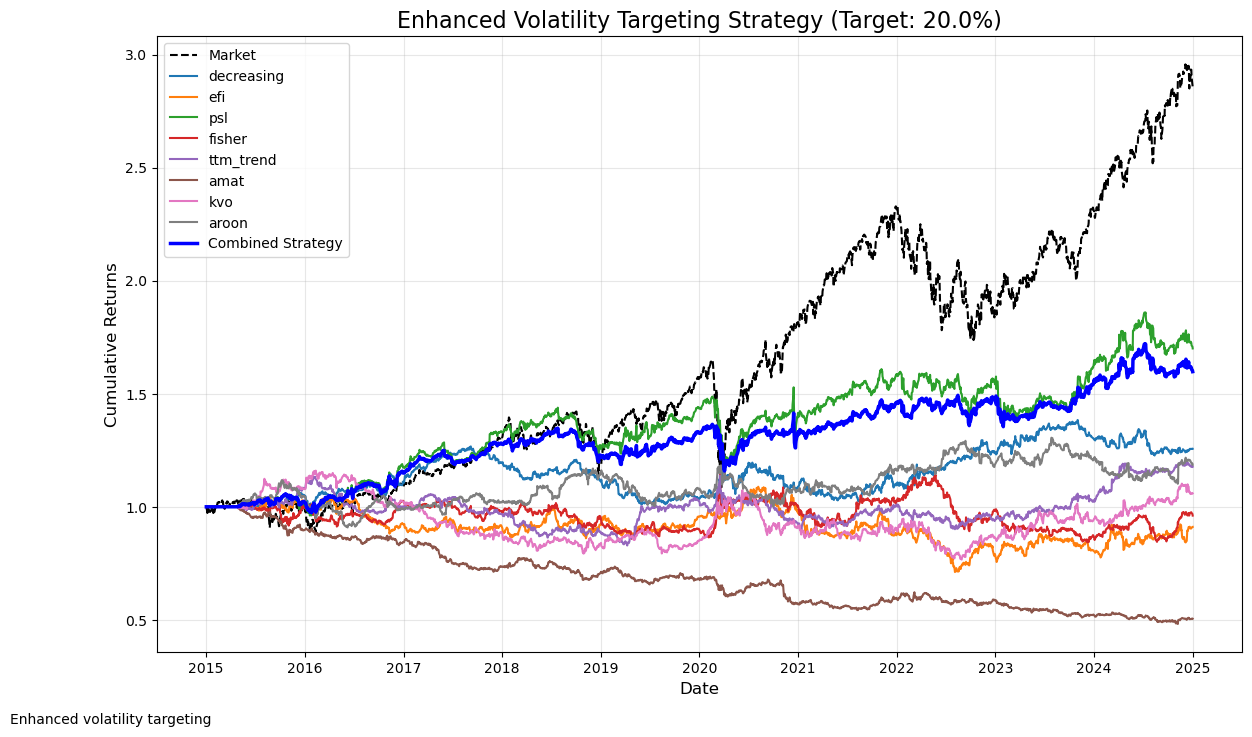

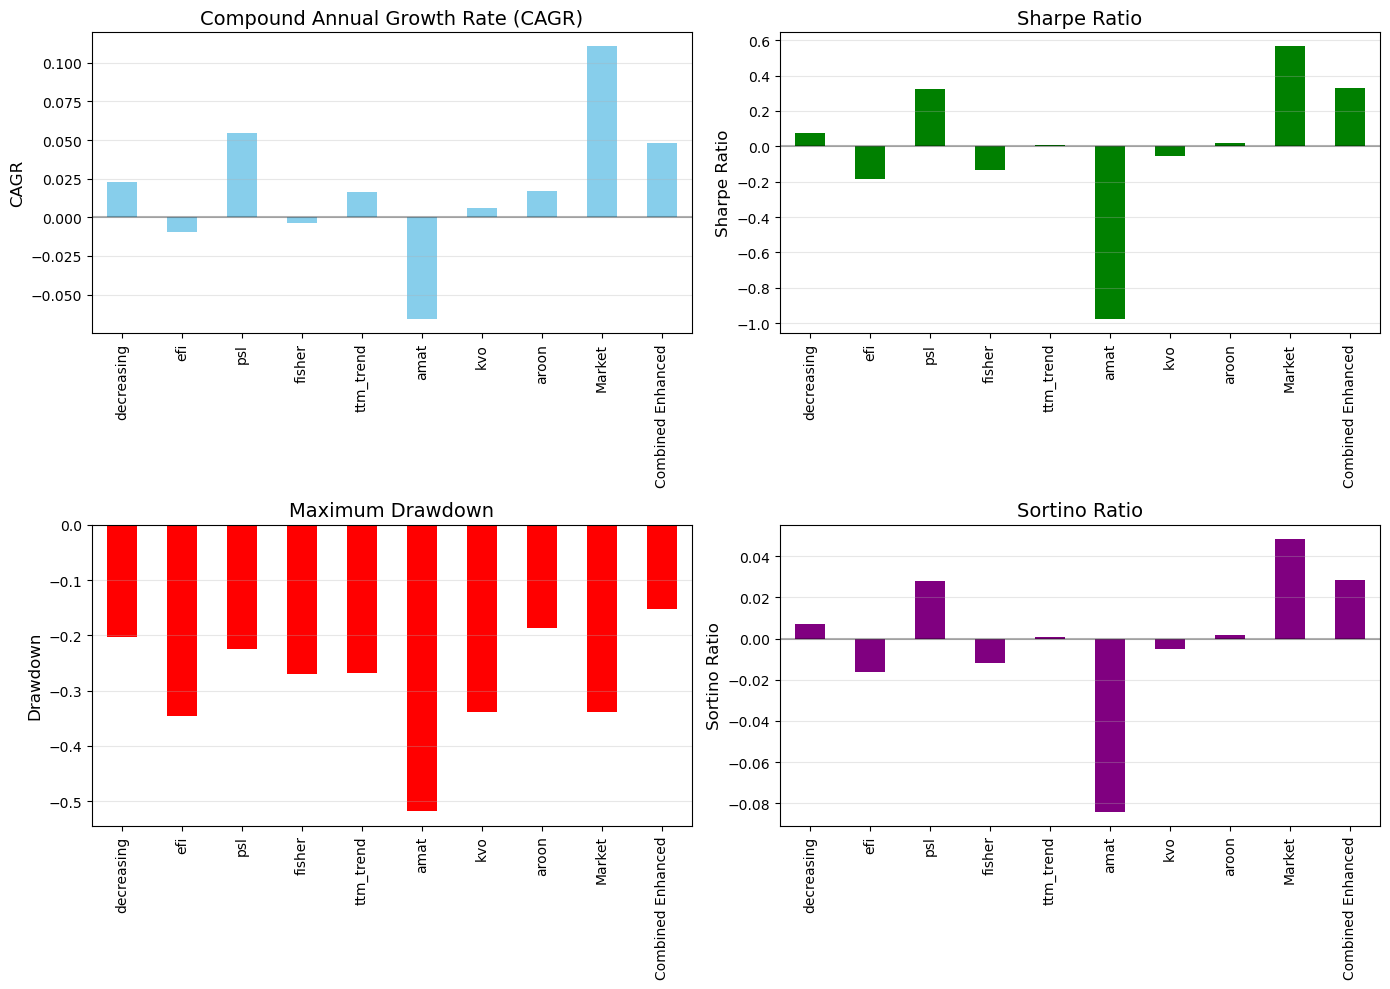


Performance Metrics Summary:
                       CAGR  Sharpe Ratio  Sortino Ratio  Max Drawdown  \
decreasing         0.023113      0.076924       0.006940     -0.202924   
efi               -0.009281     -0.186662      -0.016432     -0.346419   
psl                0.054598      0.324934       0.027879     -0.224319   
fisher            -0.003977     -0.136550      -0.011792     -0.269600   
ttm_trend          0.016460      0.008540       0.000774     -0.268469   
amat              -0.066095     -0.979743      -0.084191     -0.518292   
kvo                0.005781     -0.054863      -0.004912     -0.338899   
aroon              0.017202      0.020711       0.001886     -0.187265   
Market             0.110858      0.567356       0.048569     -0.339250   
Combined Enhanced  0.048043      0.331797       0.028556     -0.151400   

                   Information Ratio  
decreasing                 -0.471248  
efi                        -0.593515  
psl                        -0.378674  

In [83]:
import pandas as pd
import numpy as np

# Define the signals to test based on your results
signals_to_test = [
    'decreasing',  # trend
    'efi',         # volume
    'psl',         # momentum
    'fisher',      # momentum
    'ttm_trend',   # trend
    'amat',        # trend
    'kvo',         # volume
    'aroon'        # trend
]

# Number of top/bottom stocks to include in each portfolio
n_stocks = 5

# Enhanced volatility targeting parameters
target_volatility = 0.20       # 20% target volatility (higher to boost returns)
volatility_window = 30         # Shorter window (more responsive to recent volatility)
min_periods = 15               # Minimum periods for volatility calculation
max_leverage = 5.0             # Higher maximum leverage
min_leverage = 0.5             # Minimum leverage

# Base leverage (asymmetric to boost returns)
long_leverage = 4.0            # Strongly increased long leverage
short_leverage = 1.5           # Reduced short leverage

print("Starting enhanced volatility targeting backtest...")
print(f"Signals being tested: {', '.join(signals_to_test)}")
print(f"Strategy: Long top {n_stocks} / Short bottom {n_stocks} stocks per signal")
print(f"Target volatility: {target_volatility*100}%")
print(f"Leverage range: {min_leverage}x - {max_leverage}x")
print(f"Base leverage: Long={long_leverage}x, Short={short_leverage}x")

# Make sure you load your data before running this
# combined_df - MultiIndex DataFrame with signal values
# returns_df - MultiIndex DataFrame with stock returns
# market_returns_df - DataFrame with market returns (has 'Market_Returns' column)

# Run the enhanced backtest
enhanced_results = run_enhanced_backtest(
    combined_df,
    returns_df,
    market_returns,
    signals_to_test,
    n_stocks=n_stocks,
    rebalance_freq='M',        # Monthly rebalancing
    target_volatility=target_volatility,
    volatility_window=volatility_window,
    min_periods=min_periods,
    max_leverage=max_leverage,
    min_leverage=min_leverage,
    long_leverage=long_leverage,
    short_leverage=short_leverage
)

print("\nEnhanced Volatility Targeting Backtest Complete!")
print("The results have been saved to CSV files and performance charts have been generated.")

### Alpha decomposition

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def calculate_alpha(strategy_returns, market_returns, risk_free_rate=0.02/252):
    """
    Calculate Jensen's Alpha for a strategy compared to the market.
    
    Parameters:
    strategy_returns: Series with strategy returns
    market_returns: Series with market returns
    risk_free_rate: Risk-free rate (annualized, converted to daily)
    
    Returns:
    alpha: Annualized alpha
    beta: Beta to the market
    """
    # Align the data
    common_idx = strategy_returns.index.intersection(market_returns.index)
    if len(common_idx) == 0:
        return np.nan, np.nan
    
    strategy_returns = strategy_returns.loc[common_idx]
    market_returns = market_returns.loc[common_idx]
    
    # Calculate excess returns
    excess_strategy = strategy_returns - risk_free_rate
    excess_market = market_returns - risk_free_rate
    
    # Calculate beta (covariance / variance)
    covariance = np.cov(excess_strategy, excess_market)[0, 1]
    variance = np.var(excess_market)
    
    if variance == 0:
        beta = 0
    else:
        beta = covariance / variance
    
    # Calculate alpha
    alpha = np.mean(excess_strategy) - beta * np.mean(excess_market)
    
    # Annualize alpha (assuming daily returns)
    alpha_annualized = alpha * 252
    
    return alpha_annualized, beta

def analyze_strategy_alpha(backtest_results, enhanced_results=None):
    """
    Analyze alpha generation for both standard and enhanced strategies.
    Specifically designed for the exact structure shown in the example.
    
    Parameters:
    backtest_results: Results from standard ranking strategies
    enhanced_results: Optional results from enhanced volatility targeting strategies
    
    Returns:
    DataFrame with alpha and beta for all strategies
    """
    alpha_data = []
    
    # Process standard strategies - EXACT STRUCTURE FROM EXAMPLE
    print("Analyzing alpha for standard ranking strategies...")
    standard_strategies = backtest_results['individual_results']['individual_results']
    
    for signal, results in standard_strategies.items():
        strategy_returns = results['portfolio_returns']
        market_returns = results['market_returns']
        
        alpha, beta = calculate_alpha(strategy_returns, market_returns)
        
        alpha_data.append({
            'Strategy': f"{signal} (Standard)",
            'Alpha': alpha,
            'Beta': beta,
            'Type': 'Standard Ranking'
        })
    
    # Add combined standard strategy if available
    for combined_type in ['combined_equal', 'combined_sharpe']:
        if combined_type in backtest_results:
            combined_returns = backtest_results[combined_type]['combined_returns']
            market_returns = backtest_results[combined_type]['market_returns']
            
            alpha, beta = calculate_alpha(combined_returns, market_returns)
            
            alpha_data.append({
                'Strategy': f"Combined {combined_type.split('_')[1].capitalize()} (Standard)",
                'Alpha': alpha,
                'Beta': beta,
                'Type': 'Standard Ranking'
            })
    
    # Process enhanced strategies if provided - EXACT STRUCTURE FROM EXAMPLE
    if enhanced_results is not None:
        print("Analyzing alpha for enhanced volatility targeting strategies...")
        enhanced_strategies = enhanced_results['individual_results']['individual_results']
        
        for signal, results in enhanced_strategies.items():
            strategy_returns = results['portfolio_returns']
            market_returns = results['market_returns']
            
            alpha, beta = calculate_alpha(strategy_returns, market_returns)
            
            alpha_data.append({
                'Strategy': f"{signal} (Enhanced)",
                'Alpha': alpha,
                'Beta': beta,
                'Type': 'Volatility Targeting'
            })
        
        # Add combined enhanced strategy if available
        for combined_type in ['combined_equal', 'combined_sharpe', 'combined_sortino']:
            if combined_type in enhanced_results:
                combined_returns = enhanced_results[combined_type]['combined_returns']
                market_returns = enhanced_results[combined_type]['market_returns']
                
                alpha, beta = calculate_alpha(combined_returns, market_returns)
                
                alpha_data.append({
                    'Strategy': f"Combined {combined_type.split('_')[1].capitalize()} (Enhanced)",
                    'Alpha': alpha,
                    'Beta': beta,
                    'Type': 'Volatility Targeting'
                })
    
    # Create DataFrame
    alpha_df = pd.DataFrame(alpha_data)
    
    # Sort by alpha (descending)
    alpha_df = alpha_df.sort_values('Alpha', ascending=False)
    
    return alpha_df

def plot_alpha_comparison(alpha_df, save_path=None):
    """
    Plot alpha comparison for all strategies.
    
    Parameters:
    alpha_df: DataFrame with alpha analysis
    save_path: Optional path to save the plot
    """
    plt.figure(figsize=(12, 8))
    
    # Create color palette based on strategy type
    colors = {'Standard Ranking': 'skyblue', 'Volatility Targeting': 'orange'}
    
    # Plot alpha values
    ax = sns.barplot(x='Strategy', y='Alpha', data=alpha_df, hue='Type', palette=colors)
    
    # Add value labels
    for i, p in enumerate(ax.patches):
        width = p.get_width()
        height = p.get_height()
        x, y = p.get_xy() 
        ax.annotate(f'{height:.4f}', (x + width/2, y + height*1.02), ha='center')
    
    plt.title('Alpha Comparison Across Strategies', fontsize=16)
    plt.xlabel('Strategy', fontsize=14)
    plt.ylabel('Annualized Alpha', fontsize=14)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    # Additional plot for alpha vs. beta
    plt.figure(figsize=(10, 8))
    
    scatter = sns.scatterplot(data=alpha_df, x='Beta', y='Alpha', hue='Type', 
                             palette=colors, s=100, alpha=0.7)
    
    # Add strategy labels
    for i, row in alpha_df.iterrows():
        strategy_name = row['Strategy'].split(' (')[0]
        plt.annotate(strategy_name, 
                    (row['Beta'], row['Alpha']),
                    xytext=(5, 5), textcoords='offset points')
    
    plt.title('Alpha vs. Beta for All Strategies', fontsize=16)
    plt.xlabel('Beta (Market Exposure)', fontsize=14)
    plt.ylabel('Annualized Alpha', fontsize=14)
    plt.axhline(y=0, color='red', linestyle='--', alpha=0.7)
    plt.axvline(x=0, color='red', linestyle='--', alpha=0.7)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path.replace('.png', '_scatter.png'), dpi=300, bbox_inches='tight')
    
    plt.show()

def summarize_alpha_results(alpha_df):
    """
    Provide a summary of alpha results with insights.
    
    Parameters:
    alpha_df: DataFrame with alpha analysis
    
    Returns:
    String with summary insights
    """
    if len(alpha_df) == 0:
        return "No alpha data available for analysis."
        
    # Get best and worst strategies
    best_strategy = alpha_df.iloc[0]
    worst_strategy = alpha_df.iloc[-1]
    
    # Calculate average alpha by strategy type
    avg_by_type = alpha_df.groupby('Type')['Alpha'].mean().reset_index()
    
    # Calculate percentage of strategies with positive alpha
    positive_alpha = alpha_df[alpha_df['Alpha'] > 0]
    positive_pct = len(positive_alpha) / len(alpha_df) * 100
    
    # Generate insights
    insights = f"""
    ALPHA ANALYSIS SUMMARY
    ======================
    
    Best performing strategy: {best_strategy['Strategy']} with alpha of {best_strategy['Alpha']:.4f}
    Worst performing strategy: {worst_strategy['Strategy']} with alpha of {worst_strategy['Alpha']:.4f}
    
    Average alpha by strategy type:
    """
    
    for _, row in avg_by_type.iterrows():
        insights += f"    - {row['Type']}: {row['Alpha']:.4f}\n"
    
    insights += f"\n    {positive_pct:.1f}% of strategies generated positive alpha\n"
    
    # Add specific insights about volatility targeting vs. standard ranking
    if 'Volatility Targeting' in alpha_df['Type'].values and 'Standard Ranking' in alpha_df['Type'].values:
        vol_target_alpha = alpha_df[alpha_df['Type'] == 'Volatility Targeting']['Alpha'].mean()
        std_alpha = alpha_df[alpha_df['Type'] == 'Standard Ranking']['Alpha'].mean()
        
        if vol_target_alpha > std_alpha:
            improvement = (vol_target_alpha - std_alpha) / abs(std_alpha) * 100 if std_alpha != 0 else float('inf')
            insights += f"\n    Volatility targeting improved average alpha by {improvement:.1f}% compared to standard ranking\n"
        else:
            reduction = (std_alpha - vol_target_alpha) / abs(std_alpha) * 100 if std_alpha != 0 else float('inf')
            insights += f"\n    Volatility targeting reduced average alpha by {reduction:.1f}% compared to standard ranking\n"
    
    # Add beta insights
    avg_beta = alpha_df['Beta'].mean()
    insights += f"\n    Average market exposure (beta): {avg_beta:.4f}\n"
    
    # Get best risk-adjusted alpha (highest alpha/beta ratio for positive alpha)
    positive_alpha_df = alpha_df[alpha_df['Alpha'] > 0].copy()
    if len(positive_alpha_df) > 0:
        positive_alpha_df['Alpha_Beta_Ratio'] = positive_alpha_df['Alpha'] / positive_alpha_df['Beta'].abs()
        best_risk_adjusted = positive_alpha_df.sort_values('Alpha_Beta_Ratio', ascending=False).iloc[0]
        insights += f"    Best risk-adjusted alpha: {best_risk_adjusted['Strategy']} (Alpha/Beta ratio: {best_risk_adjusted['Alpha_Beta_Ratio']:.4f})\n"
    
    return insights

def run_alpha_analysis(backtest_results, enhanced_results=None, save_path="alpha_analysis.png"):
    """
    Compute and visualize alpha for all strategies.
    
    Parameters:
    backtest_results: Results from standard ranking strategies
    enhanced_results: Optional results from enhanced volatility targeting strategies
    save_path: Path to save the visualization
    
    Returns:
    DataFrame with alpha analysis
    """
    print("\nComputing alpha for all strategies...")
    
    # Analyze alpha
    alpha_df = analyze_strategy_alpha(backtest_results, enhanced_results)
    
    # Print basic info about the data
    print(f"Found {len(alpha_df)} strategies to analyze")
    print(f"Standard strategies: {len(alpha_df[alpha_df['Type'] == 'Standard Ranking'])}")
    print(f"Enhanced strategies: {len(alpha_df[alpha_df['Type'] == 'Volatility Targeting'])}")
    
    if len(alpha_df) == 0:
        print("No strategy data found. Please check your input variables.")
        return pd.DataFrame()
        
    # Plot comparison
    plot_alpha_comparison(alpha_df, save_path)
    
    # Generate summary
    summary = summarize_alpha_results(alpha_df)
    print(summary)
    
    # Save results to CSV
    alpha_df.to_csv('strategy_alpha_analysis.csv', index=False)
    print("Alpha analysis saved to 'strategy_alpha_analysis.csv'")
    
    return alpha_df

Running alpha analysis using existing backtest results...

Standard Results Structure:
Keys in backtest_results: ['individual_results', 'combined_equal', 'combined_sharpe', 'metrics_summary']
Number of individual strategies: 2
Strategy names: ['individual_results', 'metrics_summary']

Enhanced Results Structure:
Keys in enhanced_results: ['individual_results', 'combined_equal', 'combined_sharpe', 'combined_sortino', 'metrics_summary']
Number of individual strategies: 8
Strategy names: ['decreasing', 'efi', 'psl', 'fisher', 'ttm_trend', 'amat', 'kvo', 'aroon']

Computing alpha for all strategies...
Analyzing alpha for standard ranking strategies...
Analyzing alpha for enhanced volatility targeting strategies...
Found 21 strategies to analyze
Standard strategies: 10
Enhanced strategies: 11


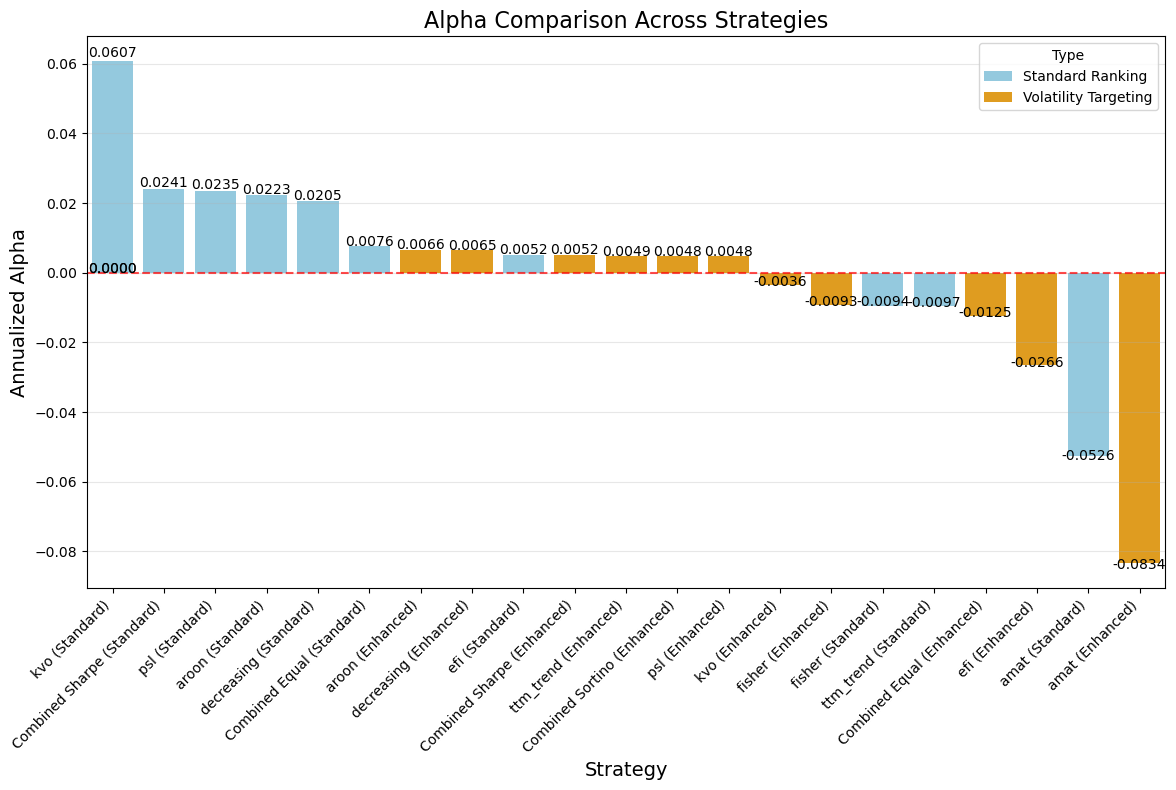

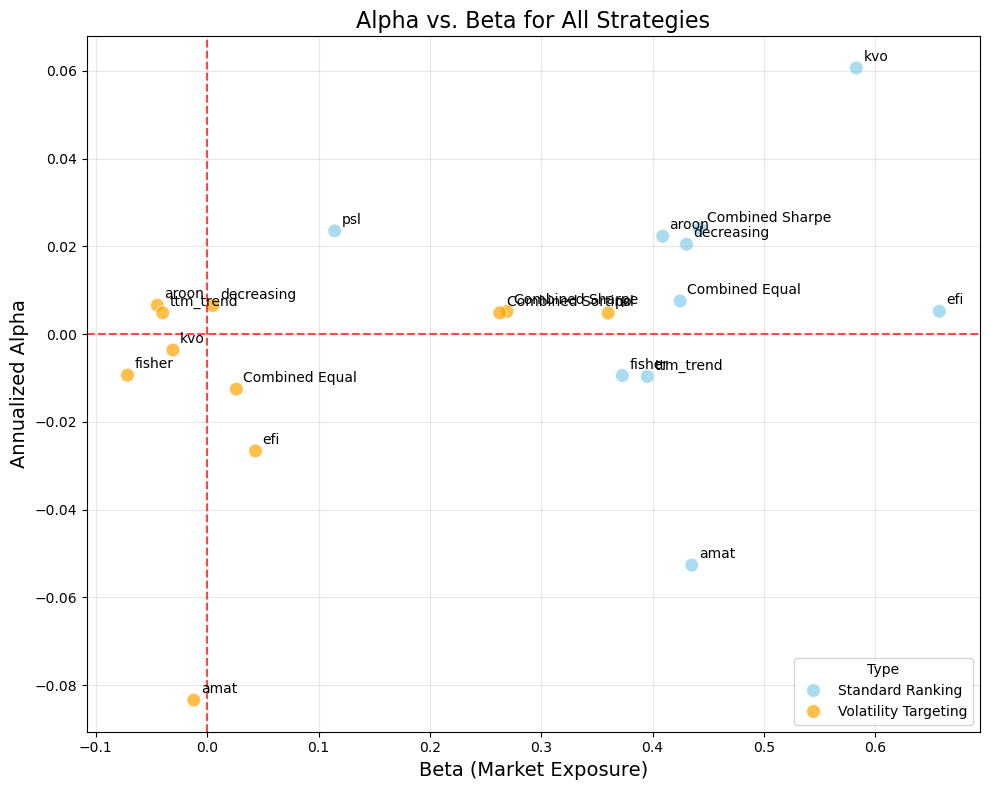


    ALPHA ANALYSIS SUMMARY
    
    Best performing strategy: kvo (Standard) with alpha of 0.0607
    Worst performing strategy: amat (Enhanced) with alpha of -0.0834
    
    Average alpha by strategy type:
        - Standard Ranking: 0.0092
    - Volatility Targeting: -0.0093

    61.9% of strategies generated positive alpha

    Volatility targeting reduced average alpha by 201.4% compared to standard ranking

    Average market exposure (beta): 0.2397
    Best risk-adjusted alpha: decreasing (Enhanced) (Alpha/Beta ratio: 1.2734)

Alpha analysis saved to 'strategy_alpha_analysis.csv'

Alpha Analysis Complete!
The analysis has been saved to 'strategy_alpha_analysis.csv'
and visualizations have been saved to 'alpha_comparison.png' and 'alpha_comparison_scatter.png'


In [111]:

# This script directly uses the backtest_results and enhanced_results variables
# that you already have from your previous backtests

print("Running alpha analysis using existing backtest results...")

# Print some debug info to verify what we're working with
print("\nStandard Results Structure:")
print(f"Keys in backtest_results: {list(backtest_results.keys())}")
if 'individual_results' in backtest_results:
    print(f"Number of individual strategies: {len(backtest_results['individual_results'])}")
    print(f"Strategy names: {list(backtest_results['individual_results'].keys())}")

print("\nEnhanced Results Structure:")
if enhanced_results is not None:
    print(f"Keys in enhanced_results: {list(enhanced_results.keys())}")
    if 'individual_results' in enhanced_results:
        if isinstance(enhanced_results['individual_results'], dict):
            if 'individual_results' in enhanced_results['individual_results']:
                # Nested structure
                print(f"Number of individual strategies: {len(enhanced_results['individual_results']['individual_results'])}")
                print(f"Strategy names: {list(enhanced_results['individual_results']['individual_results'].keys())}")
            else:
                # Direct structure
                print(f"Number of individual strategies: {len(enhanced_results['individual_results'])}")
                print(f"Strategy names: {list(enhanced_results['individual_results'].keys())}")

# Run the alpha analysis with your existing variables
alpha_df = run_alpha_analysis(
    backtest_results,       # Your standard strategy results
    enhanced_results,       # Your enhanced volatility targeting results 
    save_path="alpha_comparison.png"
)

print("\nAlpha Analysis Complete!")
print("The analysis has been saved to 'strategy_alpha_analysis.csv'")
print("and visualizations have been saved to 'alpha_comparison.png' and 'alpha_comparison_scatter.png'")